In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

import sys
sys.path.append('../')
import utils
from utils import ax_rocs, plot_rocs
from evalutils.roc import get_bootstrapped_roc_ci_curves

## directory where results are
LOCAL_PC = False
root_dir = "/mnt/w" if LOCAL_PC else "/data/bodyct"
EXPERIMENT_DIR = f"{root_dir}/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst-preds"

NLST_PREDS_LOCAL = "/mnt/c/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/nlst"
NLST_PREDS = NLST_PREDS_LOCAL ## Comment out if not using Teams backup (aka Chansey is up :)

In [2]:
nlst_preds = pd.read_csv(f'{NLST_PREDS}/nlst_demo_v1_w3preds.csv')
nlst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 88 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            16077 non-null  int64  
 1   StudyDate            16077 non-null  int64  
 2   SeriesInstanceUID    16077 non-null  object 
 3   CoordX               16077 non-null  float64
 4   CoordY               16077 non-null  float64
 5   CoordZ               16077 non-null  float64
 6   LesionID             16077 non-null  int64  
 7   NoduleType           16077 non-null  object 
 8   Spiculation          16077 non-null  bool   
 9   Diameter [mm]        16077 non-null  float64
 10  Age                  16077 non-null  int64  
 11  Gender               16077 non-null  int64  
 12  FamilyHistoryLungCa  16077 non-null  bool   
 13  Emphysema            16077 non-null  bool   
 14  NoduleInUpperLung    16077 non-null  bool   
 15  NoduleCounts         16077 non-null 

In [3]:
with open(f'{NLST_PREDS}/nlst_demo_v1_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

nlst_democols

{'num': {'demo': ['height', 'weight', 'Age'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr']},
 'cat': {'demo': ['marital', 'educat', 'race', 'ethnic', 'Gender'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld',
   'wrknomask'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop',
   'canckidn',
   'canclary',
   'canclung',
   'cancnasa',
   'cancoral',
   'cancpanc',
   'cancphar',
   'cancstom',
   'cancthyr',
   'canctran',
   'FamilyHistoryLungCa']},
 'info': ['PatientID', '

In [4]:
cols_num = sum(nlst_democols['num'].values(), start=[])
cols_cat = sum(nlst_democols['cat'].values(), start=[])
len(cols_cat)

57

In [5]:
MODEL_TO_COL = {
    "Venkadesh": "DL",
    "de Haas": "Thijmen_mean",
    # "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

Sanity check - let's see internal NLST validation results.

In [6]:
def rocs_models(df, true_col='label', models=["Venkadesh", "PanCan2b"], dataset_label="NLST", imgpath=None):
    rocs = {}
    for m in models:
        rocs[m] = get_bootstrapped_roc_ci_curves(df[MODEL_TO_COL[m]].values, df[true_col].values)

    fig, ax = plt.subplots(1,1, figsize=(8,8))
    ax_rocs(ax, rocs, title=f'{dataset_label} (n={len(df)}) ROC Curves Across Models')
    plt.show()

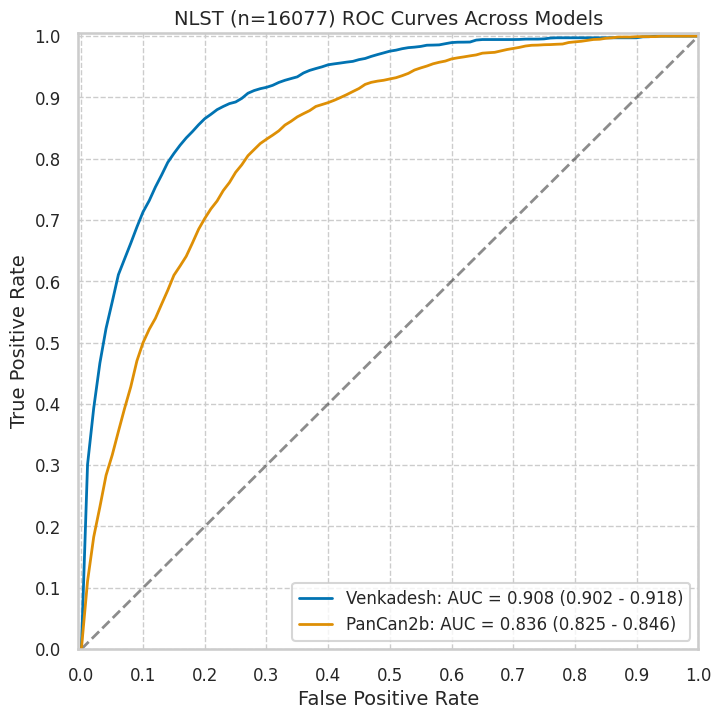

In [7]:
rocs_models(nlst_preds)

## Plot results by category

In [22]:
def plot_by_category(df, cat, models=['Venkadesh', 'PanCan2b']):
    groups = df.groupby(cat)
    plot_roc = True

    cat_info = {'num': [], 'pct': [], 'num_mal': [], 'pct_mal': []}
    cat_vals = []
    for val, df_group in groups:
        cat_vals.append(val)
        cat_info['num'].append(len(df_group))
        cat_info['pct'].append(100 * len(df_group) / len(df))
        cat_info['num_mal'].append(len(df_group.query('label == 1')))
        cat_info['pct_mal'].append(100 * len(df_group.query('label == 1')) / len(df_group))

        if len(df_group.query('label == 1')) == 0 or len(df_group.query('label == 1')) == len(df_group):
            plot_roc = False

    df_catinfo = pd.DataFrame(cat_info, index=cat_vals)
    display(df_catinfo)

    if not plot_roc:
        print("Not plotting ROC since there are zero values for malignant or benign nodules :(")
    else:
        rocs = {m: {} for m in models}
        for val, df_group in groups:
            y_true = df_group['label'].values
            for m in models:
                y_pred = df_group[MODEL_TO_COL[m]].values
                rocs[m][val] = get_bootstrapped_roc_ci_curves(y_pred, y_true)

        fig, ax = plt.subplots(1, len(models), figsize=(6.5*len(models) - 0.5, 6))
        fig.suptitle(f"Model Performance Split By {cat}")
        for i, m in enumerate(models):
            ax_rocs(ax[i], rocs[m], title=m)
        plt.show()

    return df_catinfo        

### Demographics

marital


num        pct  num_mal   pct_mal
1.0    644   4.005722       48  7.453416
2.0  10898  67.786279      796  7.304092
3.0   1327   8.254027      127  9.570460
4.0    206   1.281334       17  8.252427
5.0   2957  18.392735      259  8.758877

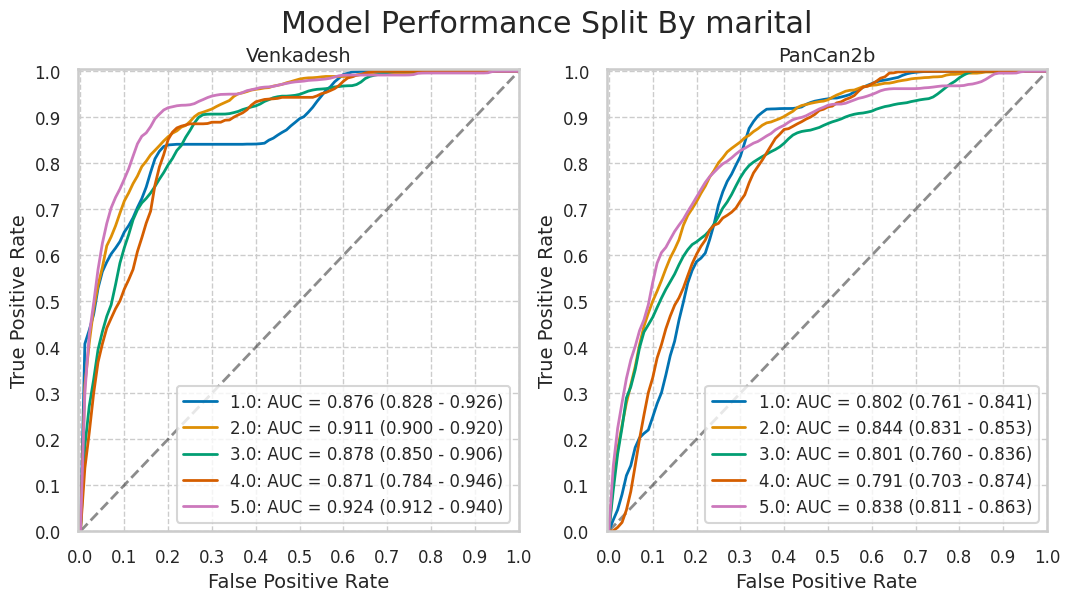

educat


num        pct  num_mal   pct_mal
1.0   268   1.666978       24  8.955224
2.0   872   5.423897       74  8.486239
3.0  4077  25.359209      311  7.628158
4.0  2307  14.349692      176  7.628955
5.0  3539  22.012813      304  8.589997
6.0  2493  15.506624      187  7.501003
7.0  2239  13.926728      145  6.476105

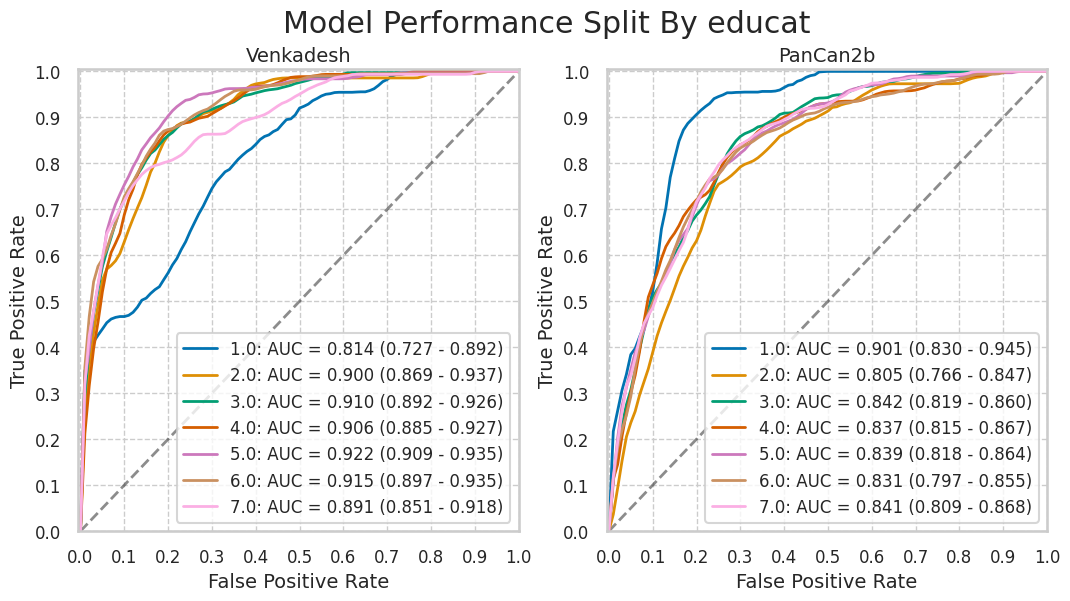

race


num        pct  num_mal    pct_mal
1.0  15040  93.549792     1145   7.613032
2.0    481   2.991852       57  11.850312
3.0    228   1.418175       21   9.210526
4.0     68   0.422964       12  17.647059
5.0     44   0.273683        2   4.545455
6.0    177   1.100952       10   5.649718

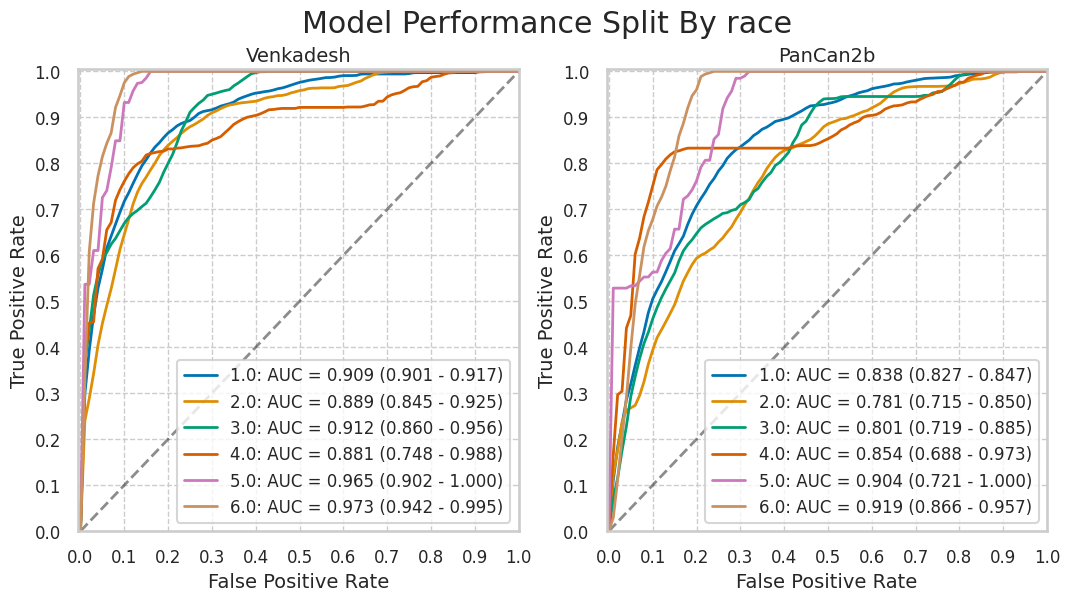

ethnic


num        pct  num_mal   pct_mal
1.0    210   1.306214        9  4.285714
2.0  15779  98.146420     1230  7.795171

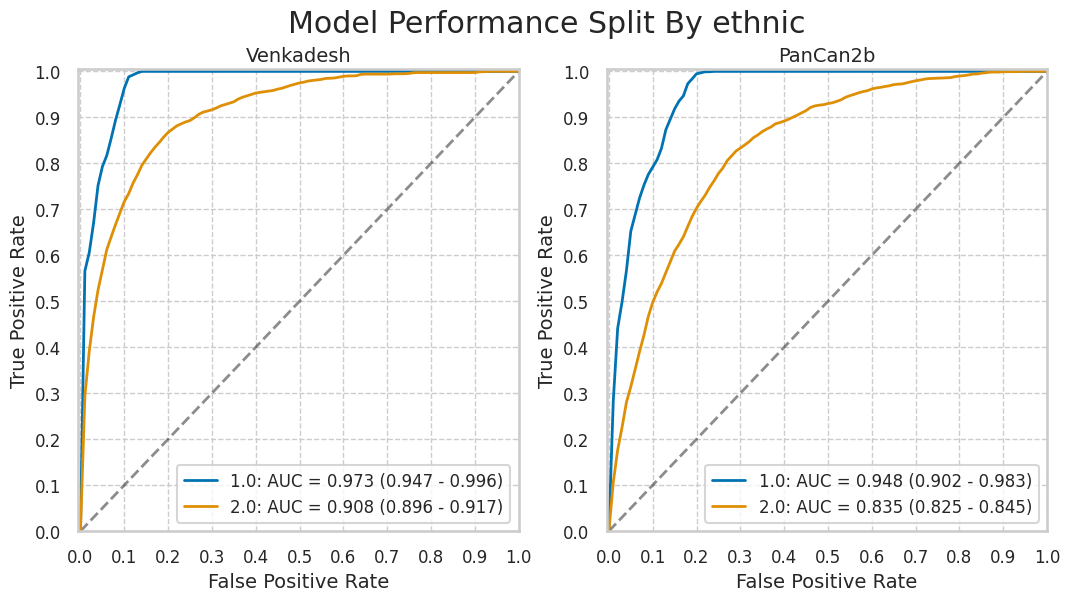

Gender


num        pct  num_mal   pct_mal
1  9281  57.728432      727  7.833208
2  6796  42.271568      522  7.680989

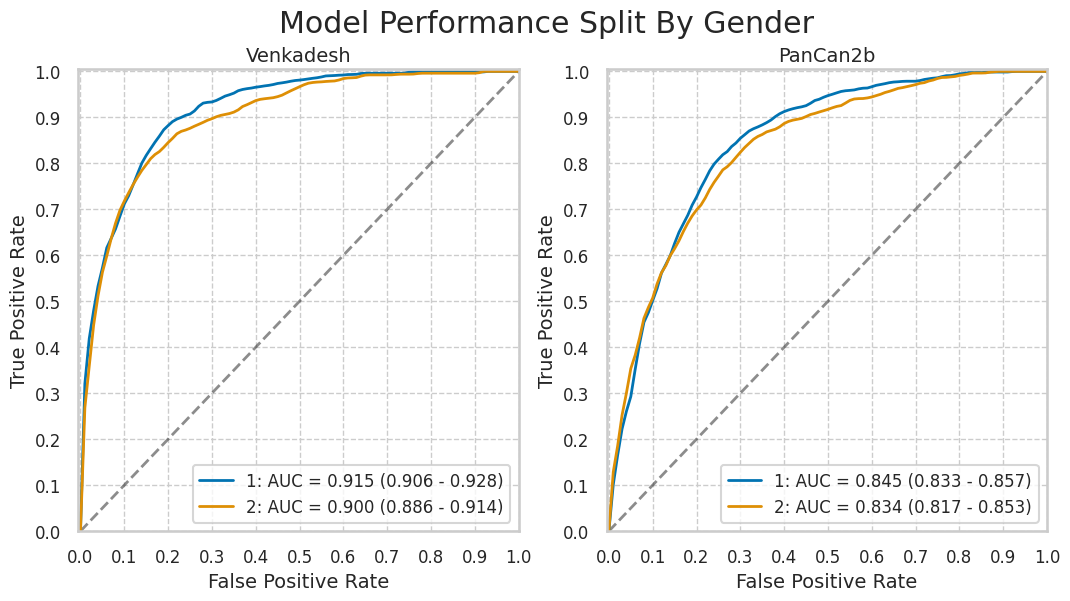

In [16]:
for cat in nlst_democols['cat']['demo']:
    print(cat)
    plot_by_category(nlst_preds, cat)

### Smoking

cigar


num        pct  num_mal   pct_mal
0.0  13031  81.053679     1005  7.712378
1.0   2996  18.635318      240  8.010681

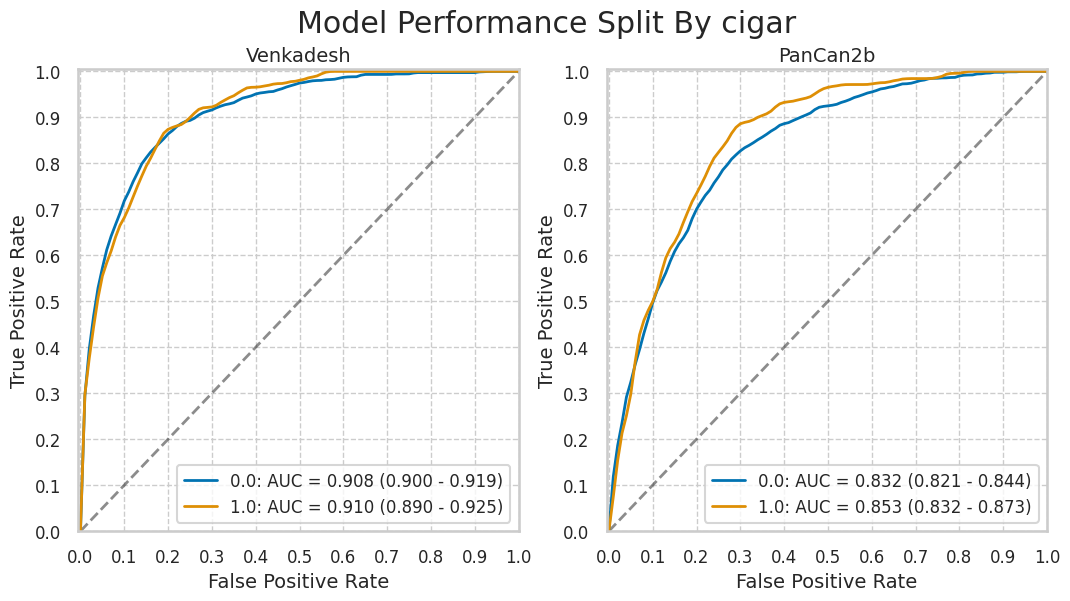

cigsmok


num        pct  num_mal   pct_mal
0  7911  49.206942      575  7.268361
1  8166  50.793058      674  8.253735

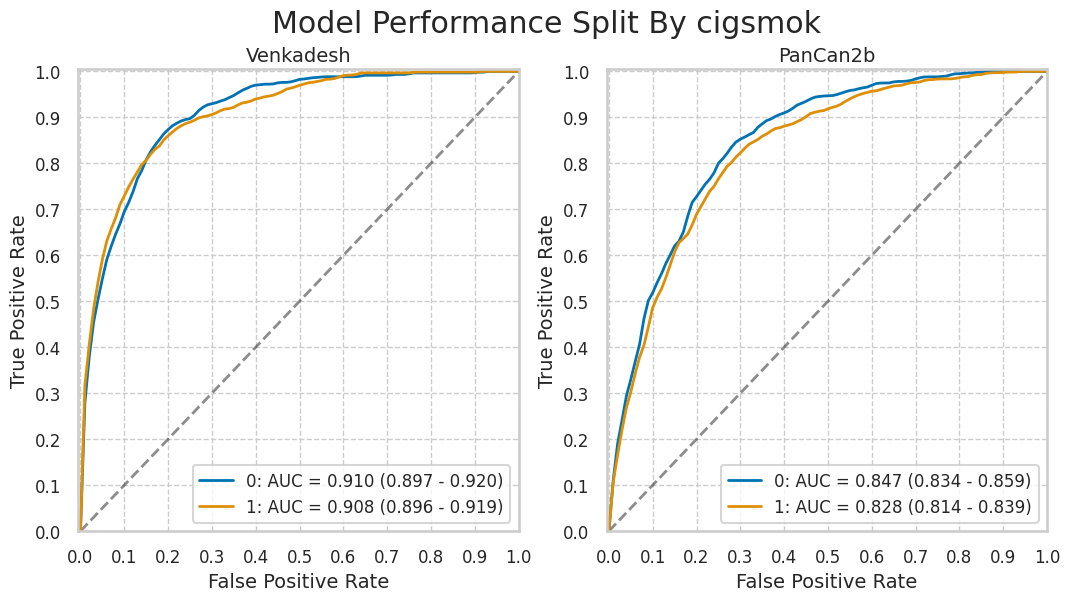

pipe


num        pct  num_mal   pct_mal
0.0  12542  78.012067      948  7.558603
1.0   3438  21.384587      297  8.638743

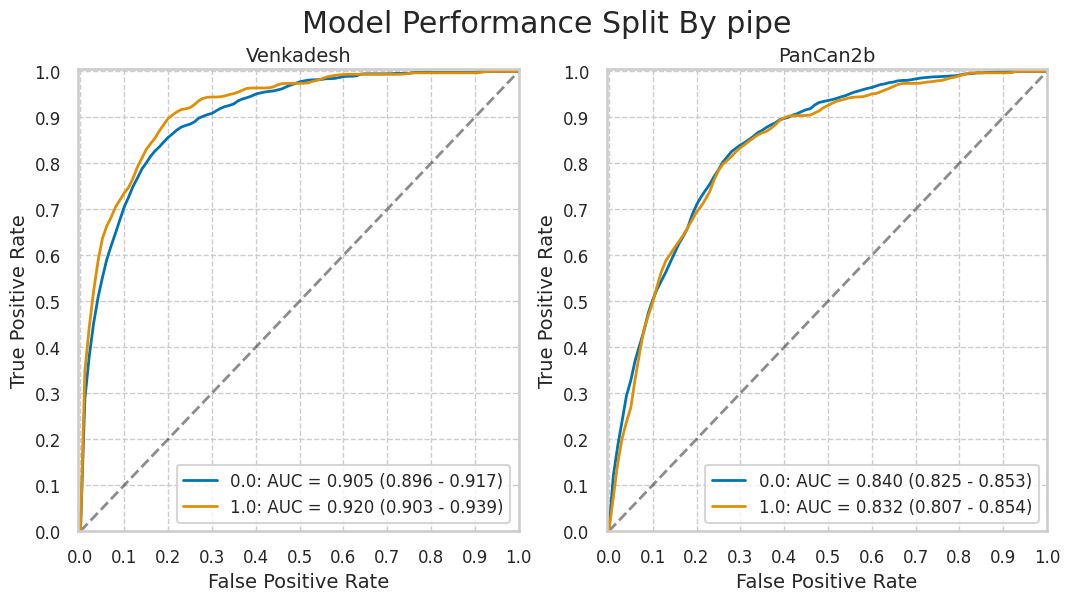

smokelive


num        pct  num_mal   pct_mal
0.0   1870  11.631523      133  7.112299
1.0  14142  87.964172     1110  7.848961

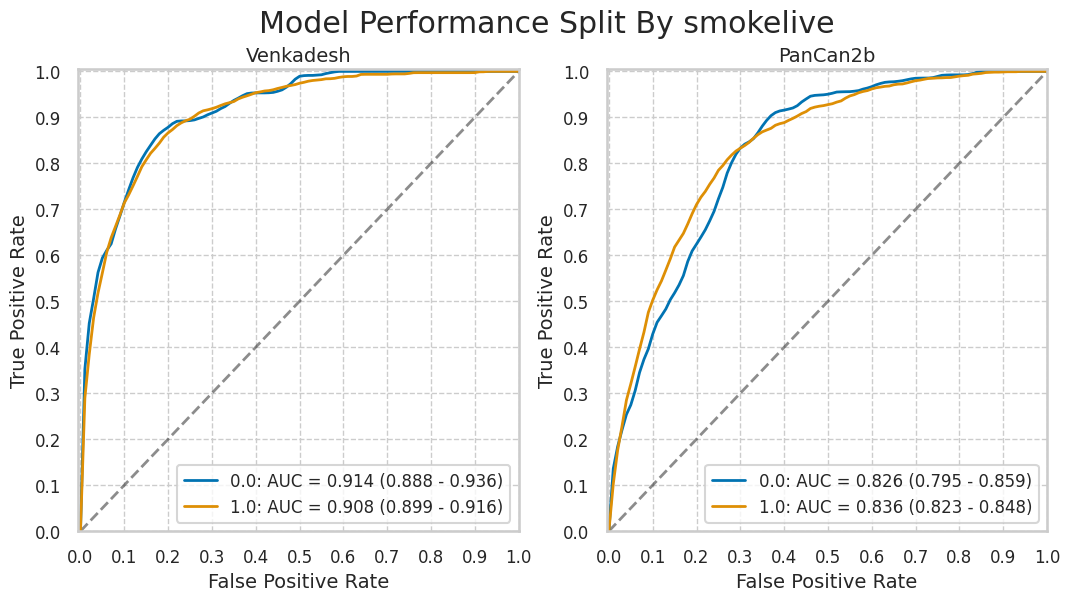

smokework


num        pct  num_mal   pct_mal
0.0   2041  12.695155      142  6.957374
1.0  13924  86.608198     1095  7.864120

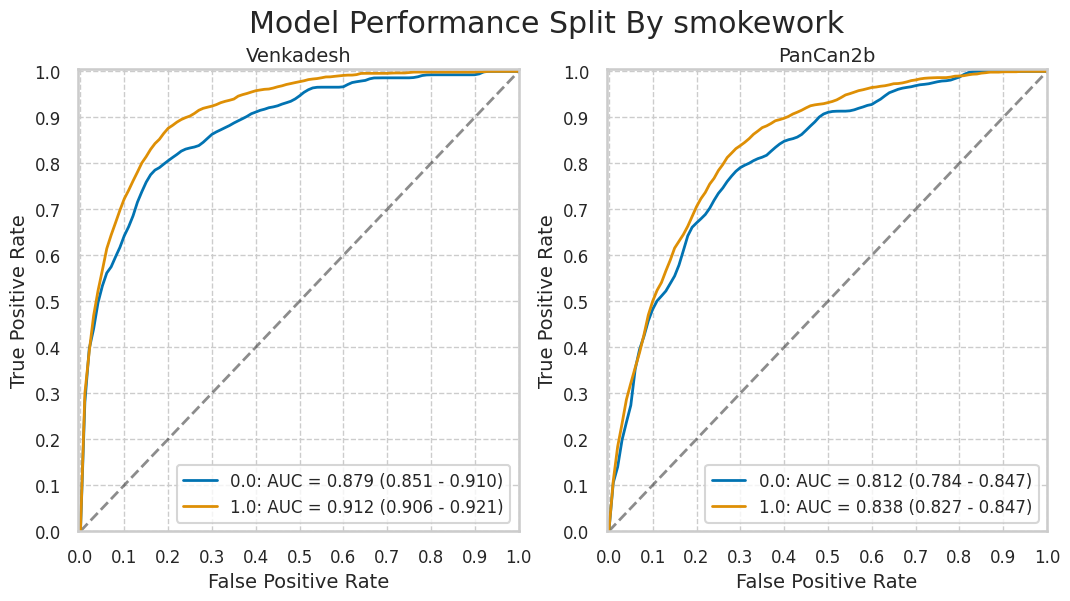

In [17]:
for cat in nlst_democols['cat']['smoke']:
    print(cat)
    plot_by_category(nlst_preds, cat)

### Work history

wrkasbe


num        pct  num_mal   pct_mal
0.0  15277  95.023947     1182  7.737121
1.0    789   4.907632       66  8.365019

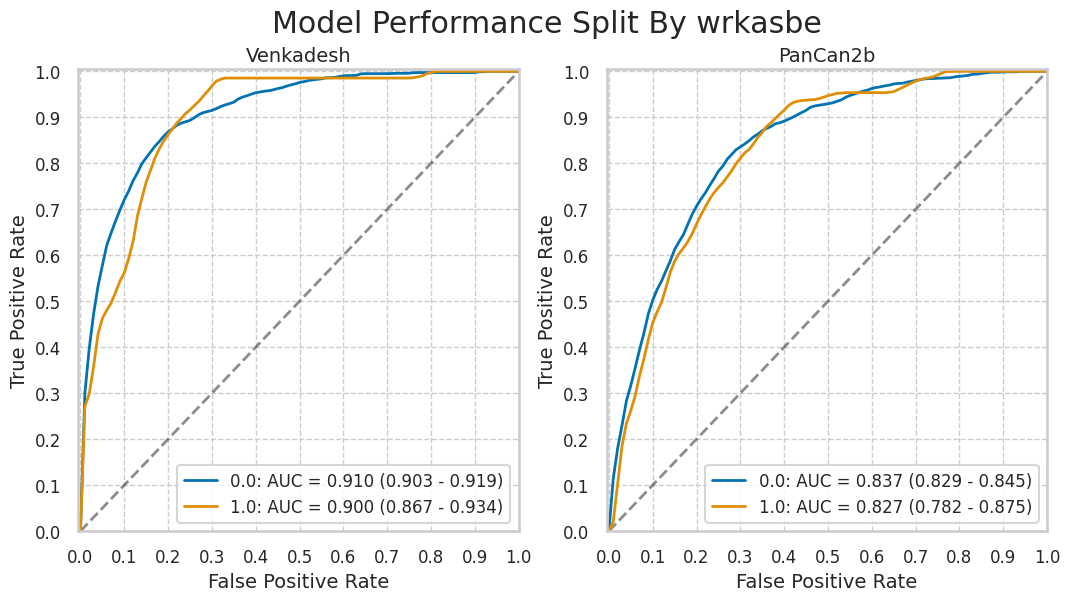

wrkbaki


num        pct  num_mal   pct_mal
0.0  15644  97.306711     1221  7.804909
1.0    432   2.687068       27  6.250000

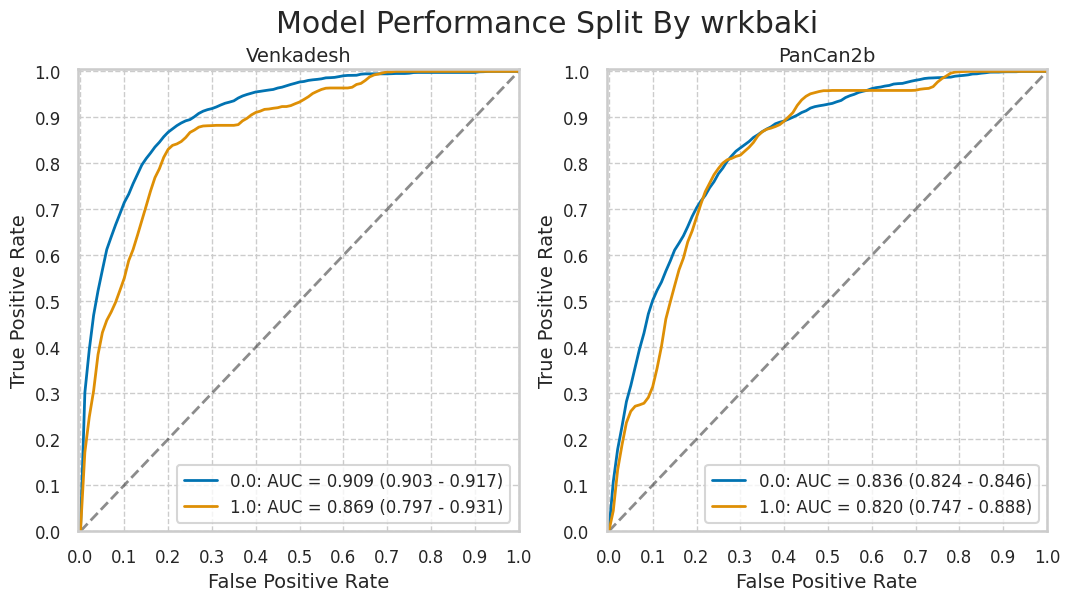

wrkbutc


num       pct  num_mal   pct_mal
0.0  15780  98.15264     1223  7.750317
1.0    296   1.84114       25  8.445946

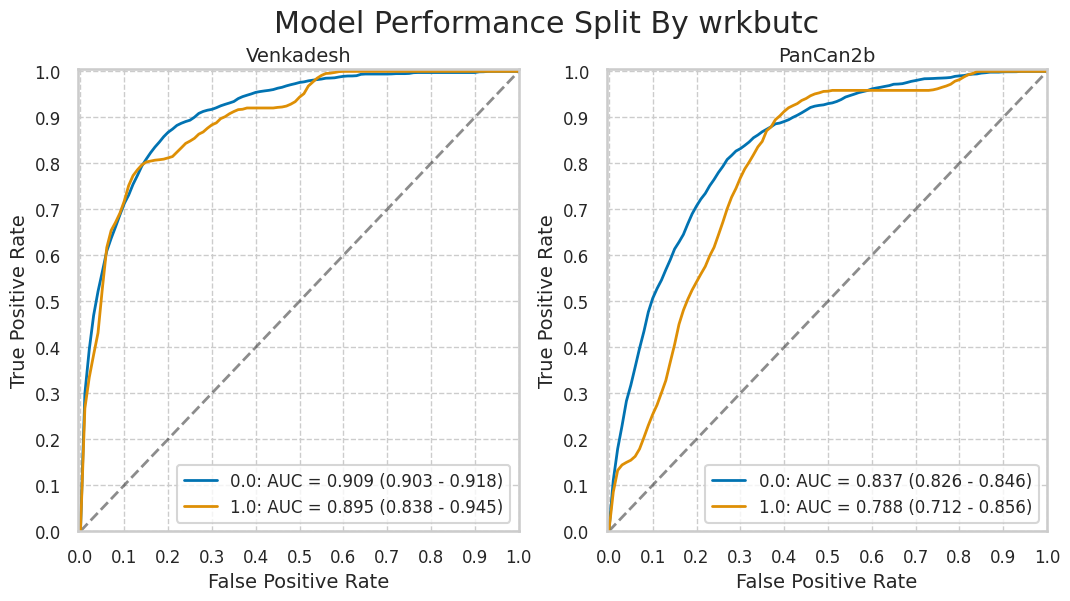

wrkchem


num        pct  num_mal   pct_mal
0.0  15000  93.300989     1171  7.806667
1.0   1063   6.611930       77  7.243650

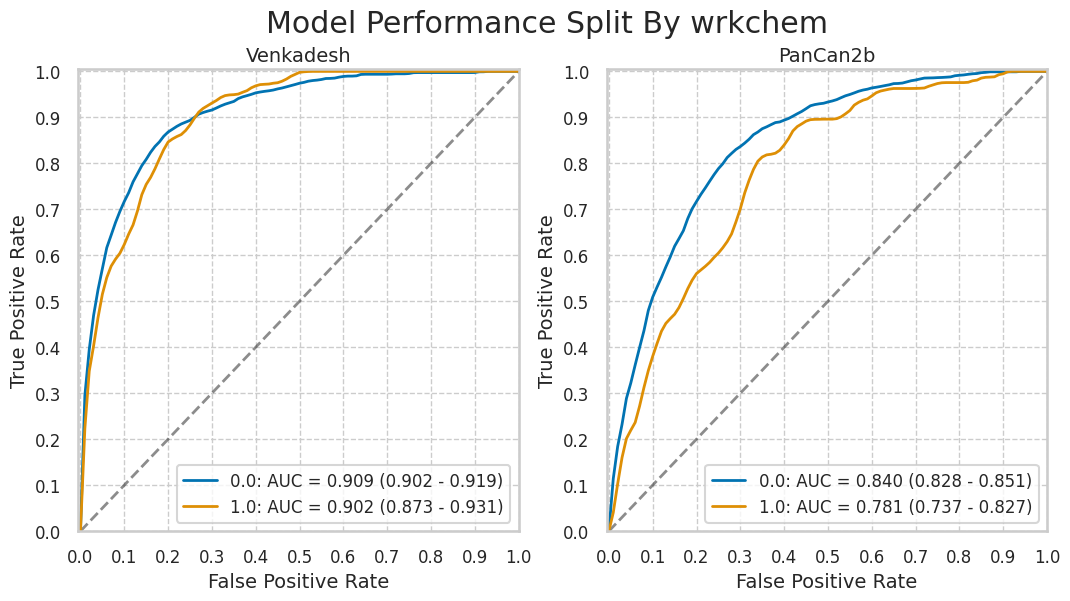

wrkcoal


num        pct  num_mal   pct_mal
0.0  15994  99.483735     1241  7.759160
1.0     82   0.510045        7  8.536585

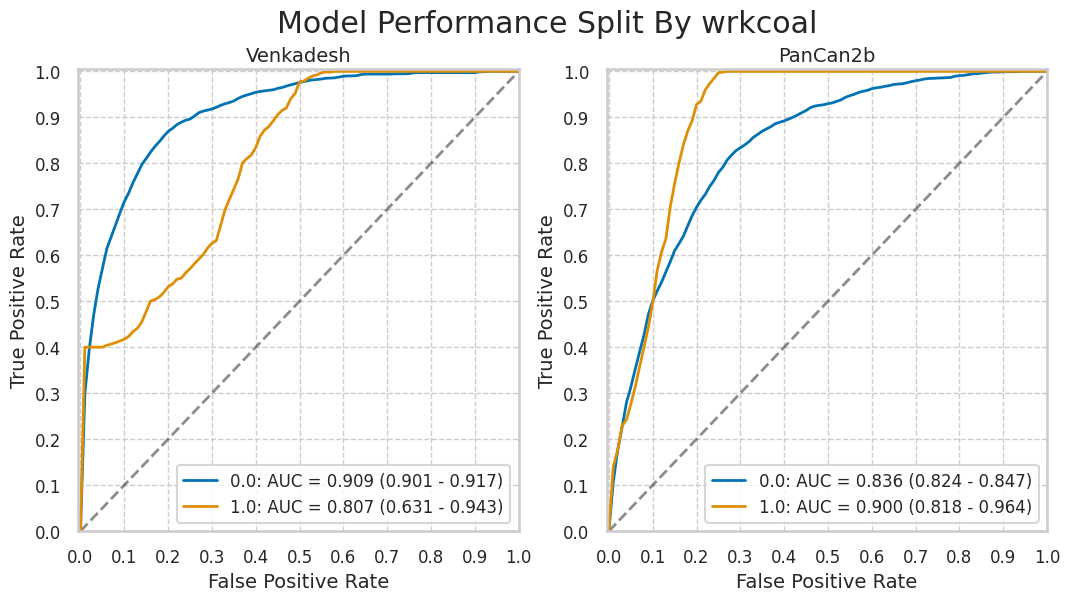

wrkcott


num        pct  num_mal    pct_mal
0.0  15950  99.210052     1232   7.724138
1.0    126   0.783728       16  12.698413

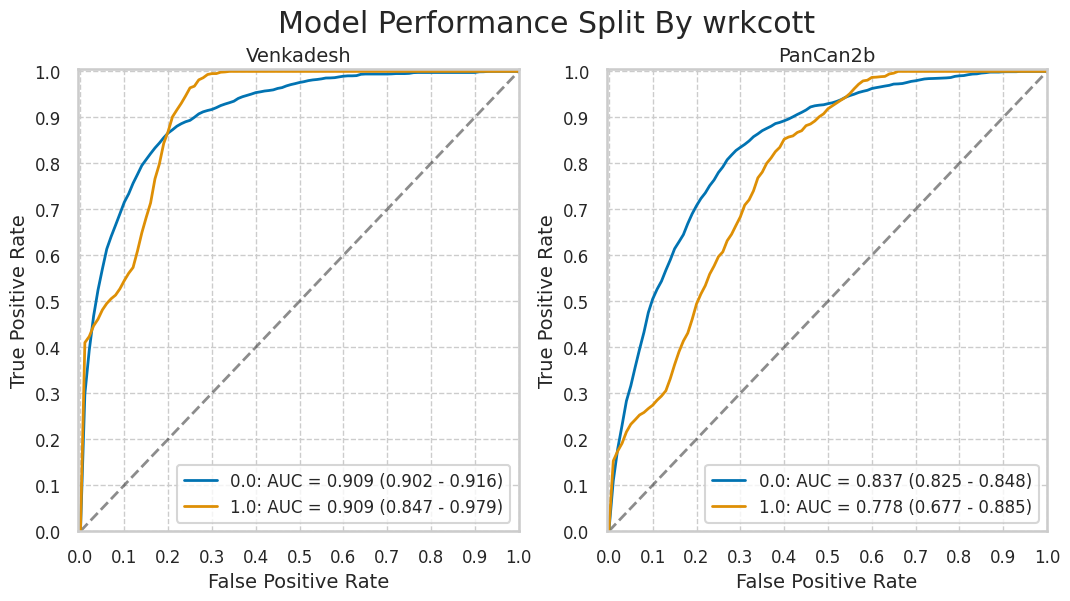

wrkfarm


num       pct  num_mal   pct_mal
0.0  14253  88.65460     1124  7.886059
1.0   1820  11.32052      121  6.648352

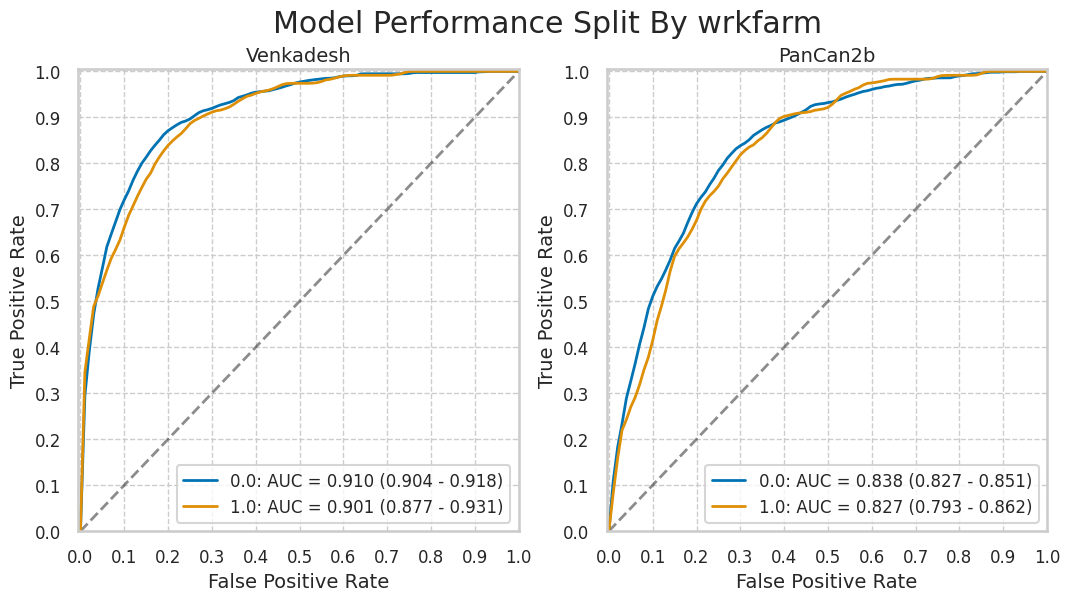

wrkfire


num        pct  num_mal    pct_mal
0.0  15808  98.326802     1219   7.711285
1.0    268   1.666978       29  10.820896

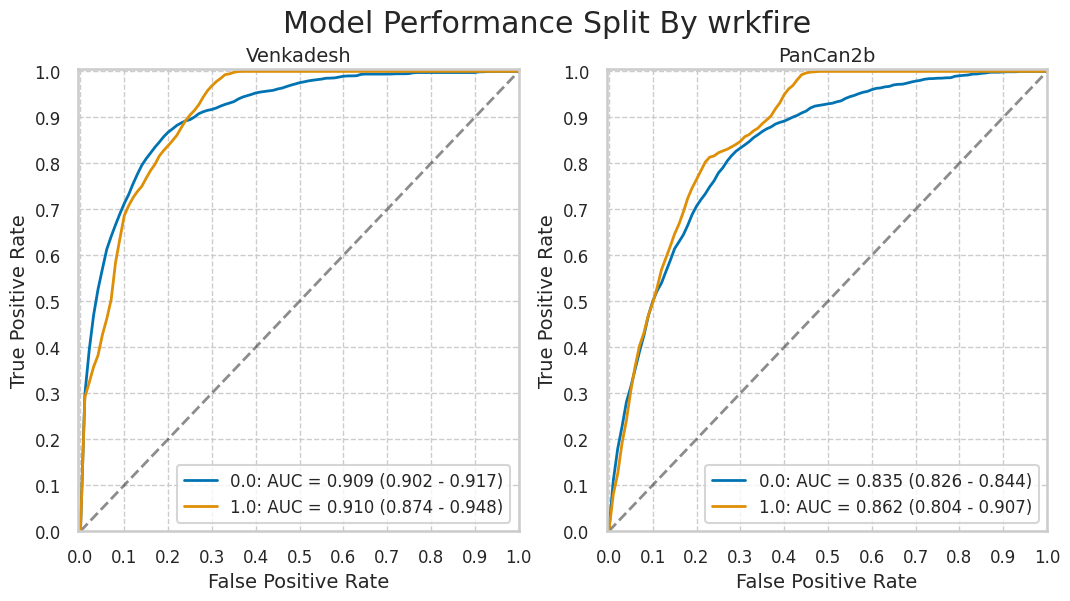

wrkflou


num       pct  num_mal   pct_mal
0.0  15926  99.06077     1230   7.72322
1.0    150   0.93301       18  12.00000

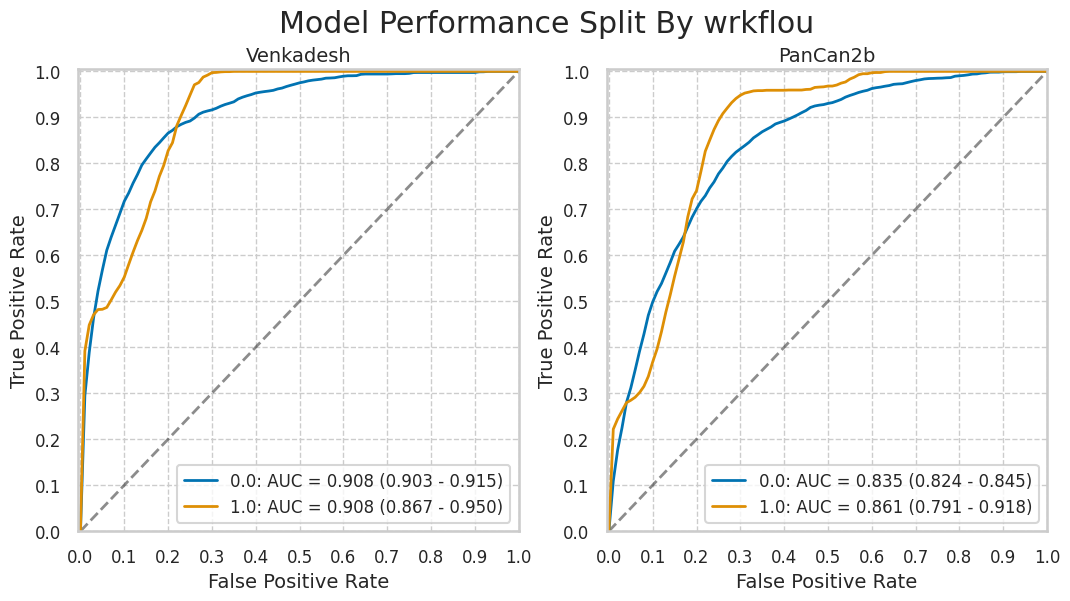

wrkfoun


num        pct  num_mal   pct_mal
0.0  15409  95.844996     1182  7.670842
1.0    667   4.148784       66  9.895052

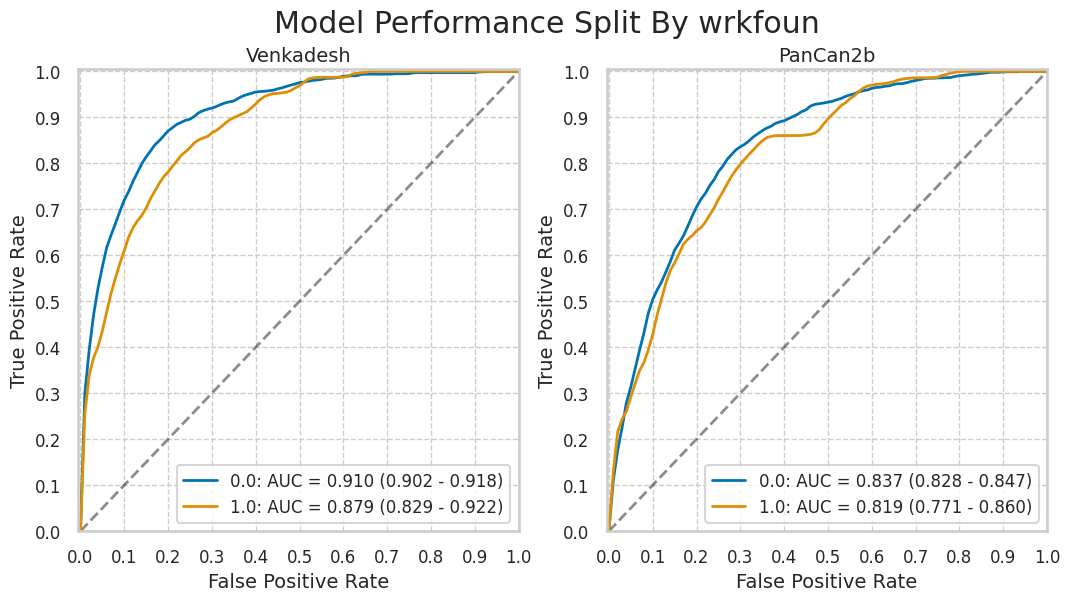

wrkhard


num        pct  num_mal   pct_mal
0.0  15957  99.253592     1245  7.802218
1.0    119   0.740188        3  2.521008

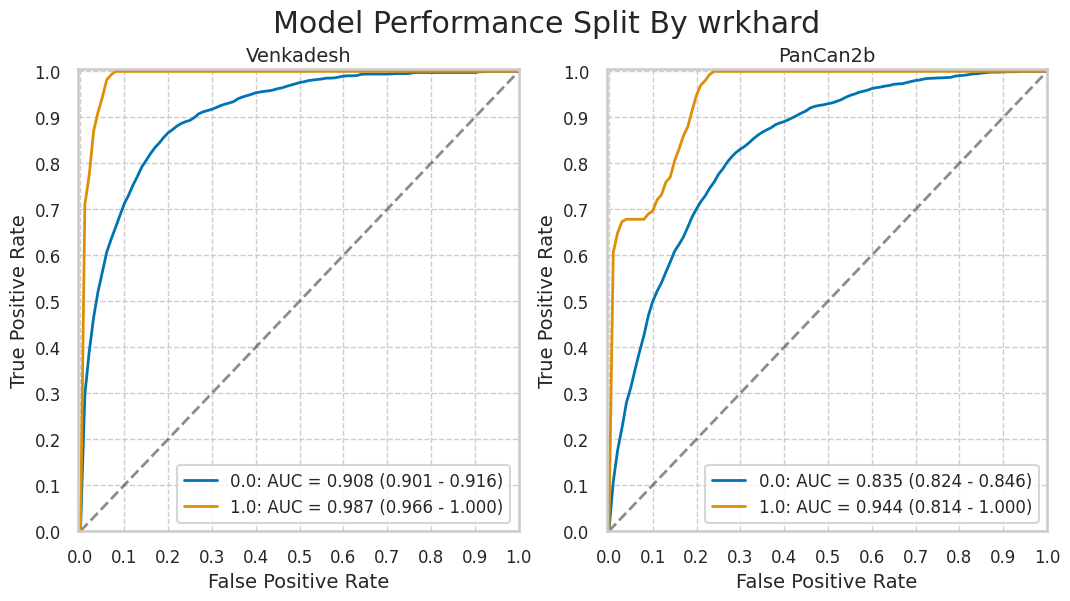

wrkpain


num        pct  num_mal   pct_mal
0.0  15262  94.930646     1171  7.672651
1.0    814   5.063134       77  9.459459

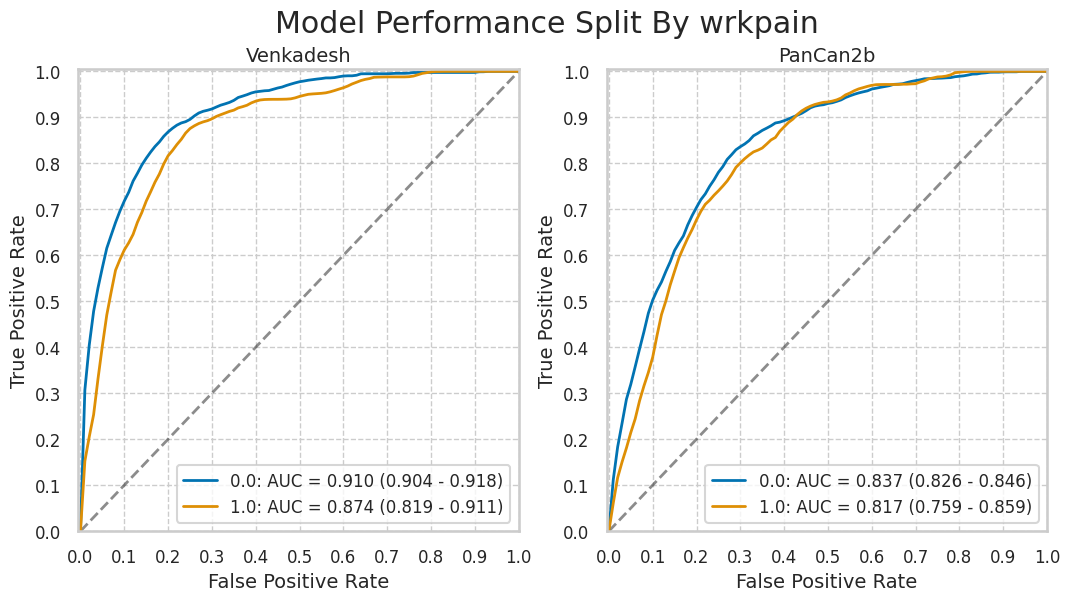

wrksand


num        pct  num_mal   pct_mal
0.0  15834  98.488524     1213   7.66073
1.0    242   1.505256       35  14.46281

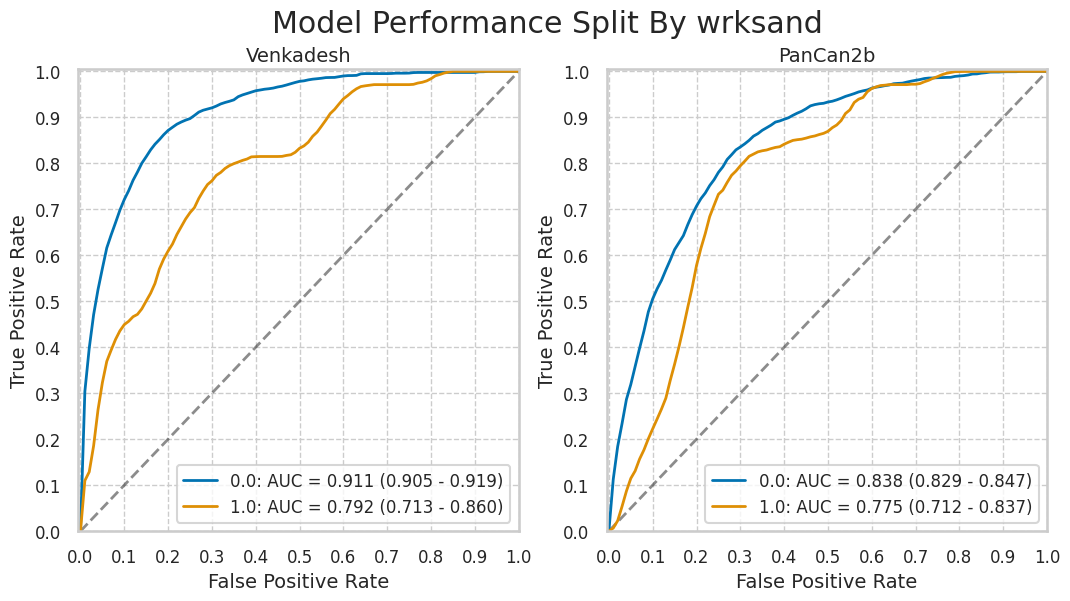

wrkweld


num        pct  num_mal   pct_mal
0.0  15145  94.202899     1159  7.652691
1.0    931   5.790881       89  9.559613

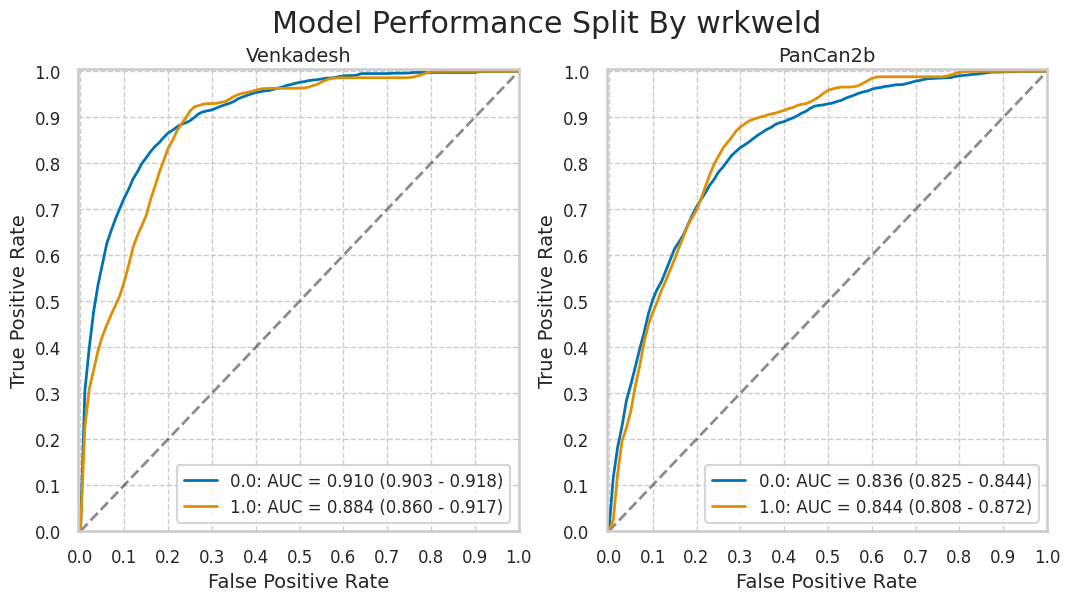

wrknomask


num        pct  num_mal   pct_mal
False  12041  74.895814      943  7.831575
True    4036  25.104186      306  7.581764

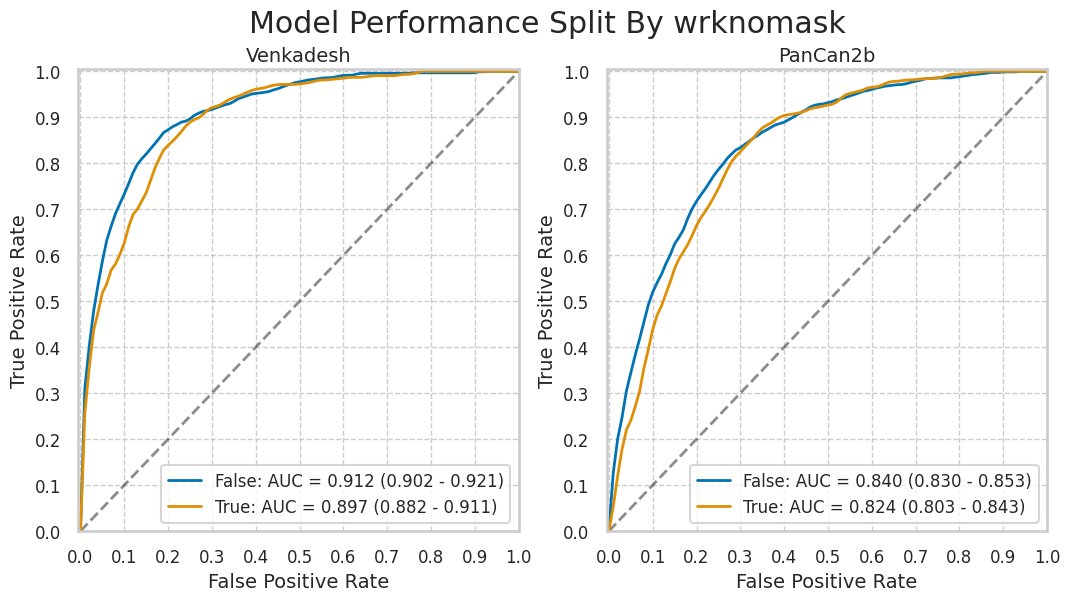

In [18]:
for cat in nlst_democols['cat']['work']:
    print(cat)
    plot_by_category(nlst_preds, cat)

### Disease history

diagadas


num        pct  num_mal   pct_mal
0.0  15015  93.394290     1159  7.718948
1.0   1038   6.456428       85  8.188825

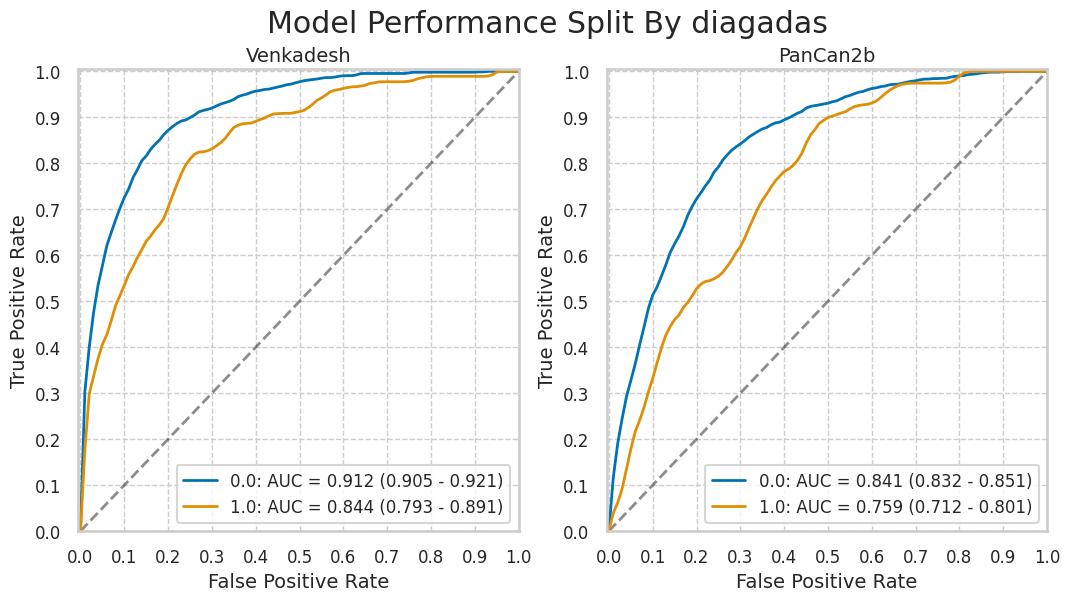

diagasbe


num        pct  num_mal   pct_mal
0.0  15884  98.799527     1236  7.781415
1.0    175   1.088512       12  6.857143

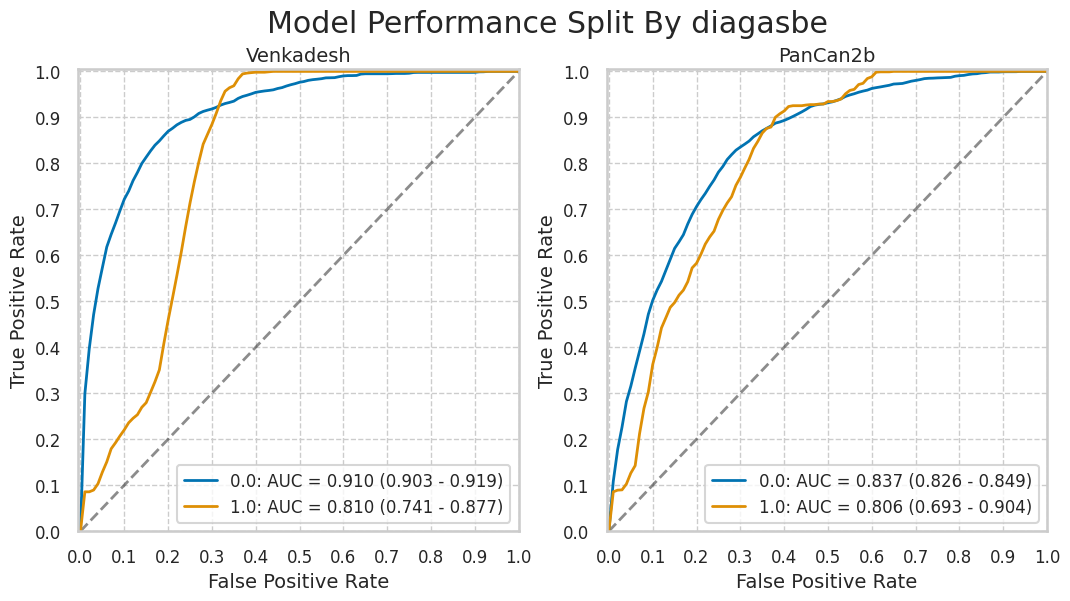

diagbron


num        pct  num_mal   pct_mal
0.0  15481  96.292841     1214  7.841871
1.0    553   3.439696       28  5.063291

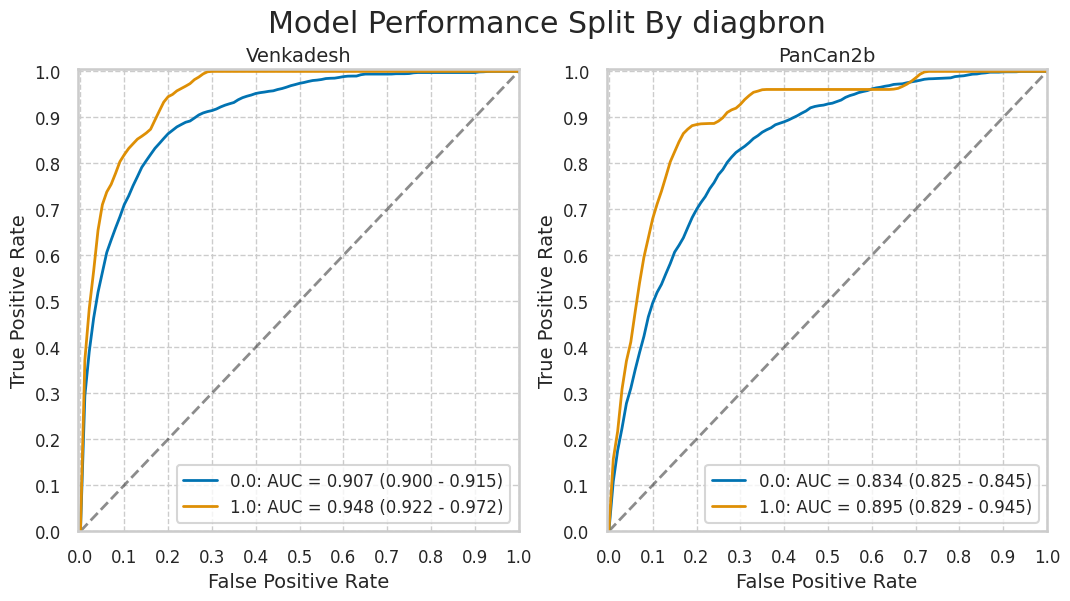

diagchas


num        pct  num_mal   pct_mal
0.0  15486  96.323941     1222  7.890998
1.0    573   3.564098       26  4.537522

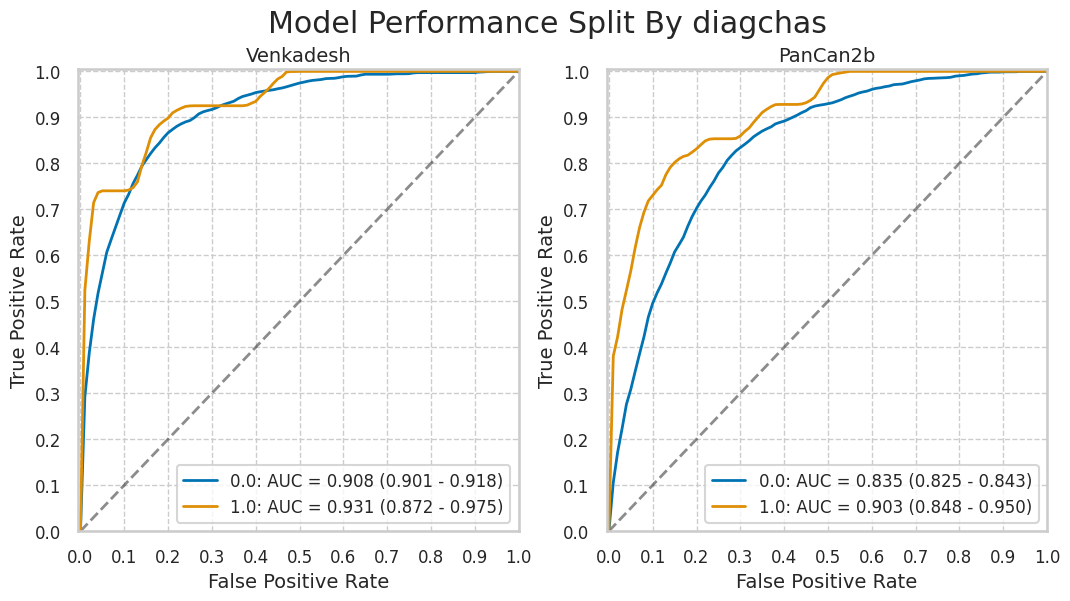

diagchro


num        pct  num_mal   pct_mal
0.0  14279  88.816321     1125  7.878703
1.0   1750  10.885115      116  6.628571

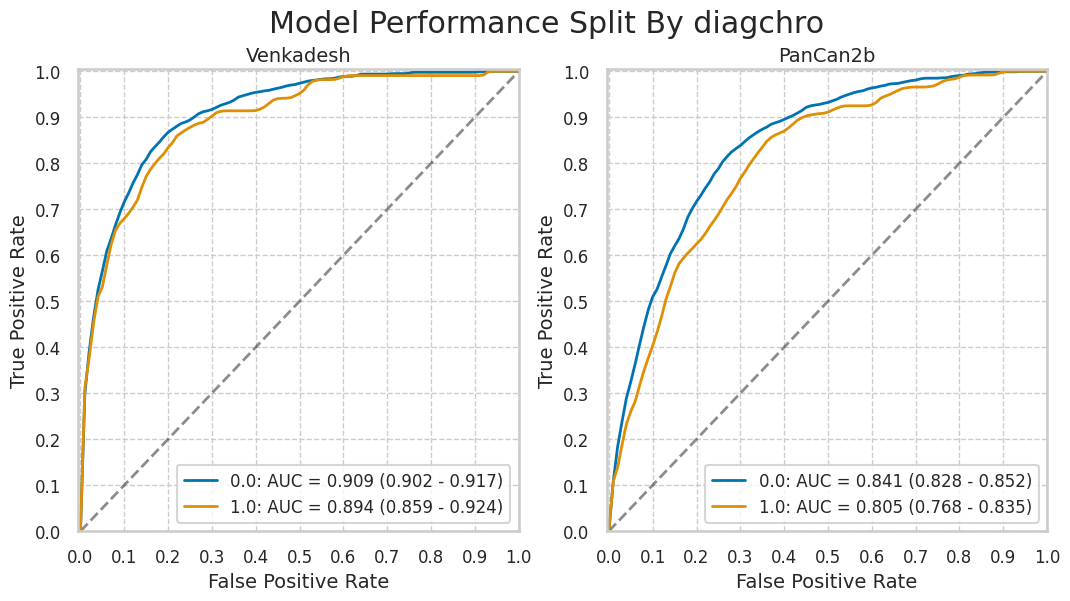

diagcopd


num        pct  num_mal    pct_mal
0.0  14905  92.710083     1122   7.527675
1.0   1131   7.034895      124  10.963749

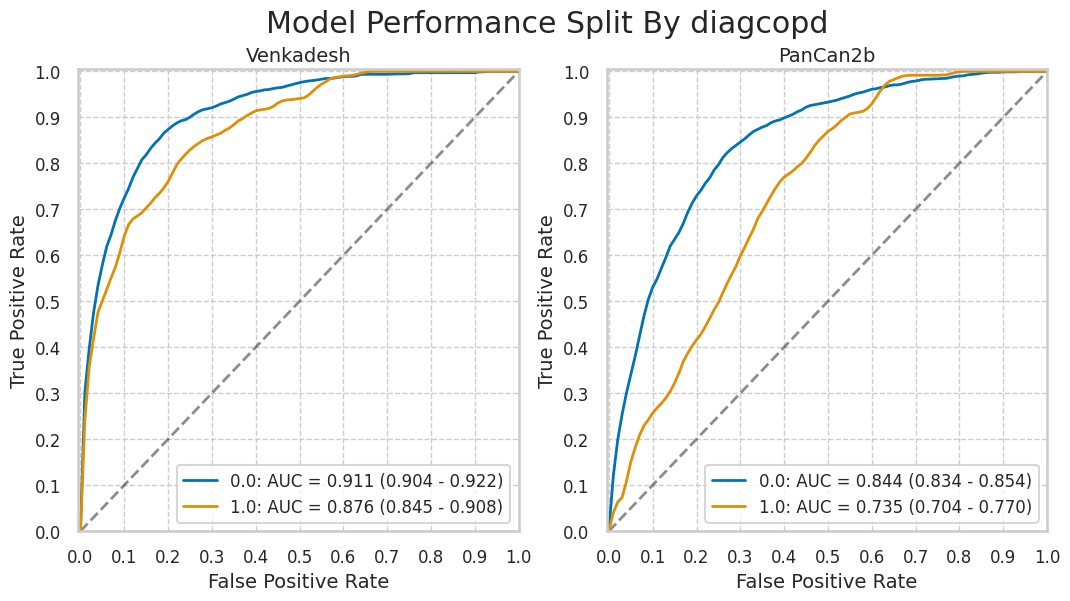

diagdiab


num        pct  num_mal   pct_mal
0.0  14428  89.743111     1123  7.783477
1.0   1632  10.151148      125  7.659314

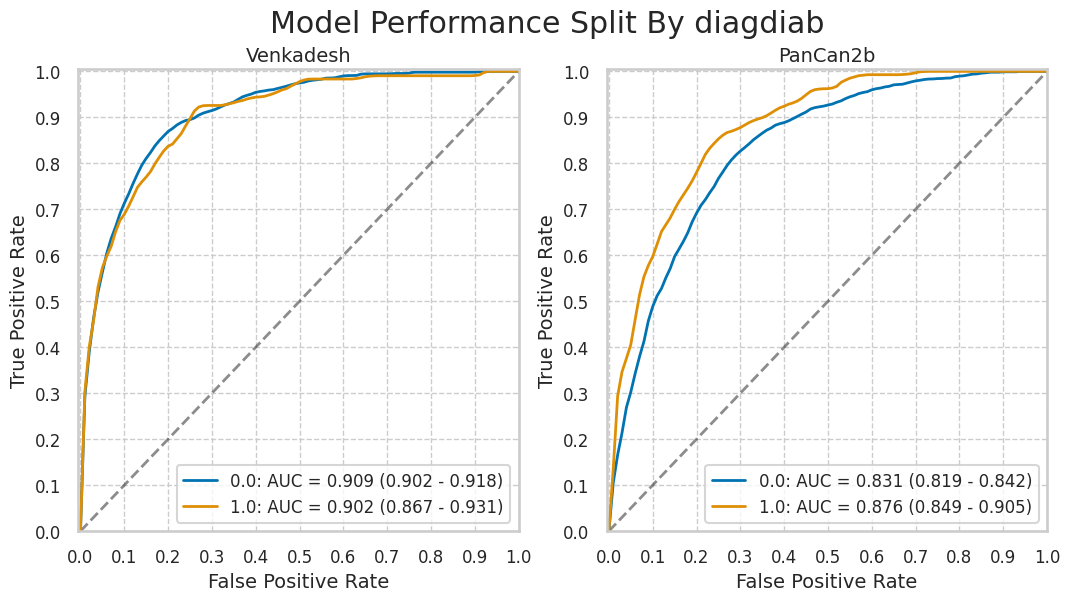

diagemph


num        pct  num_mal   pct_mal
0.0  14283  88.841202     1090  7.631450
1.0   1755  10.916216      156  8.888889

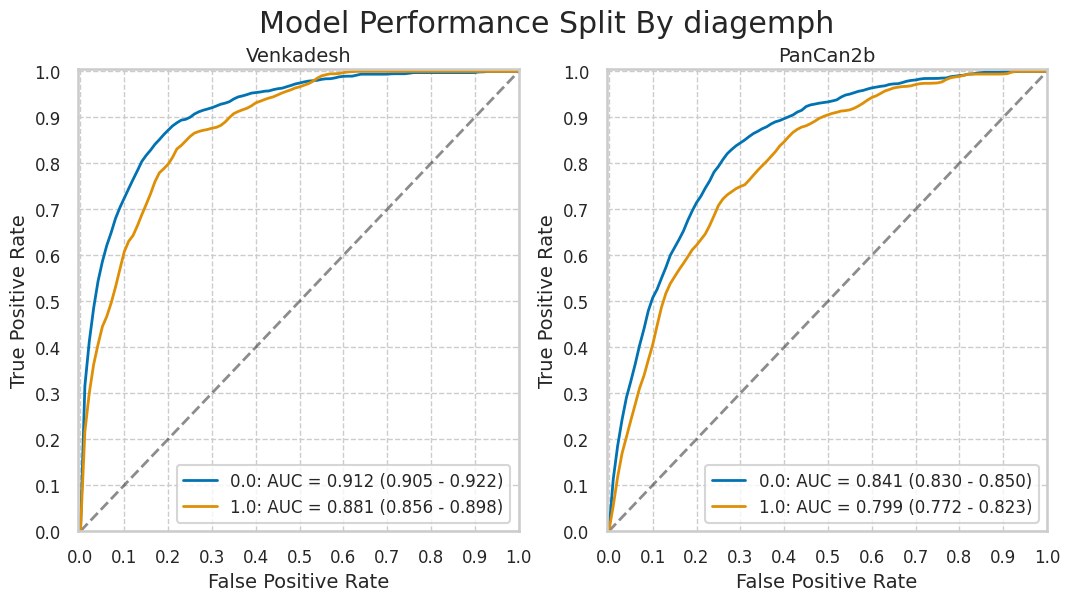

diagfibr


num        pct  num_mal    pct_mal
0.0  16016  99.620576     1243   7.760989
1.0     40   0.248803        5  12.500000

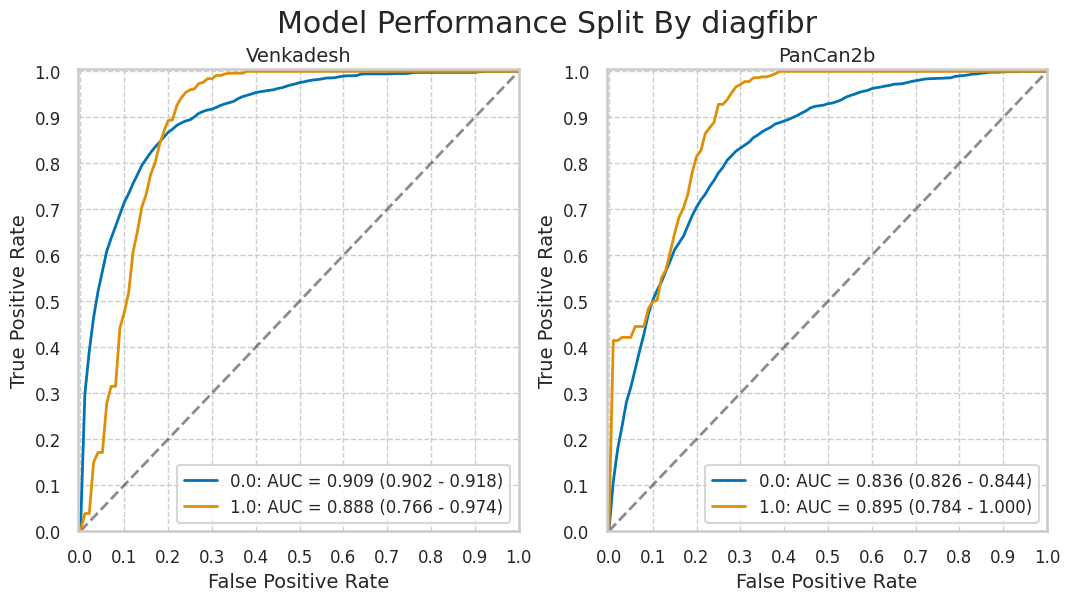

diaghear


num        pct  num_mal   pct_mal
0.0  13869  86.266094     1067  7.693417
1.0   2159  13.429122      179  8.290875

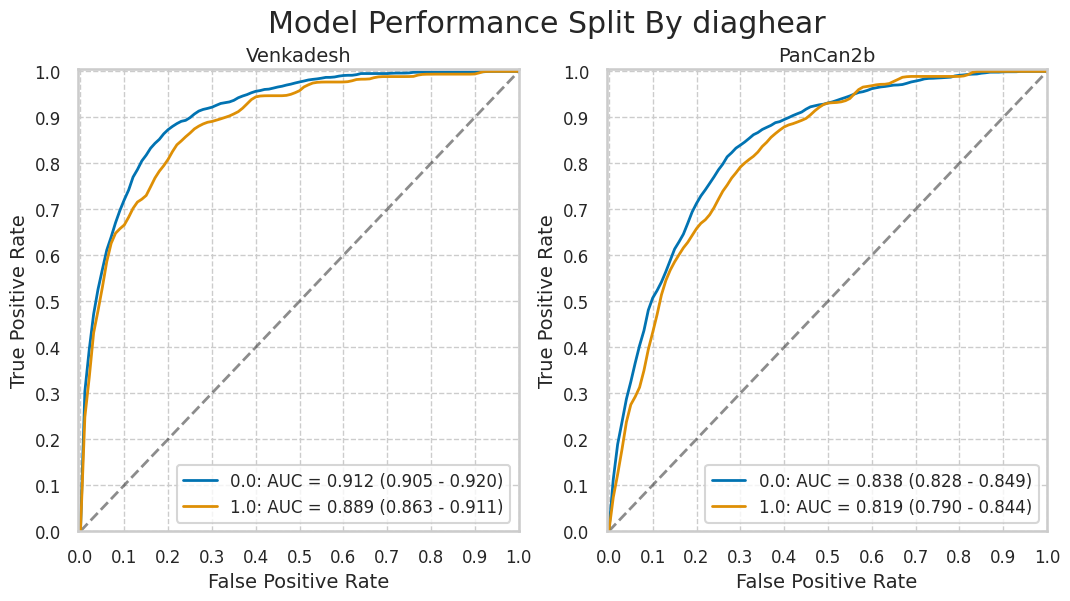

diaghype


num        pct  num_mal   pct_mal
0.0  10489  65.242272      798  7.607970
1.0   5558  34.571126      445  8.006477

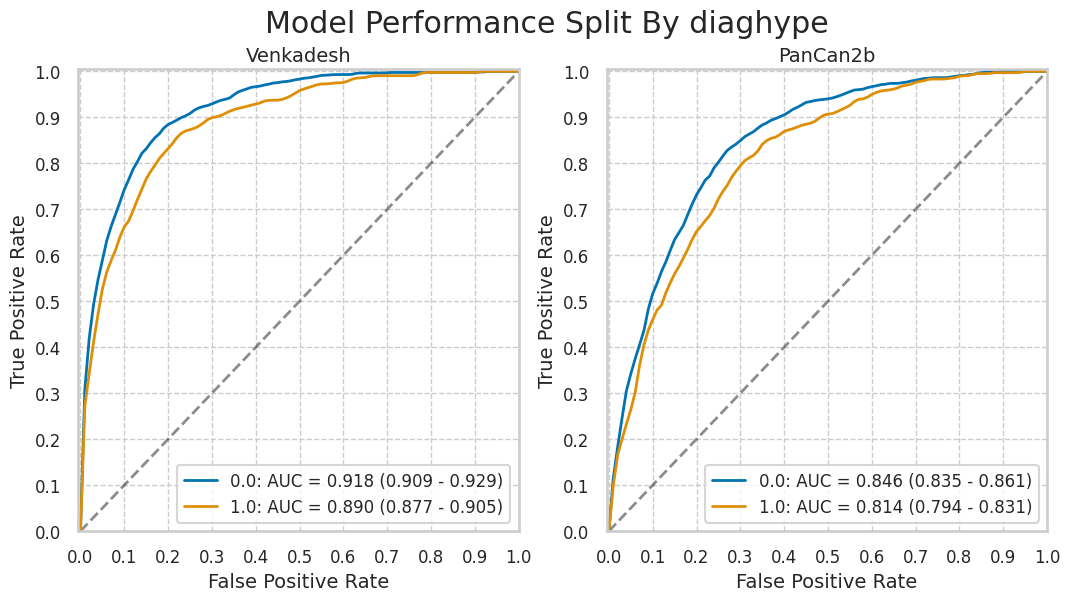

diagpneu


num        pct  num_mal   pct_mal
0.0  12297  76.488151      946  7.692933
1.0   3756  23.362568      296  7.880724

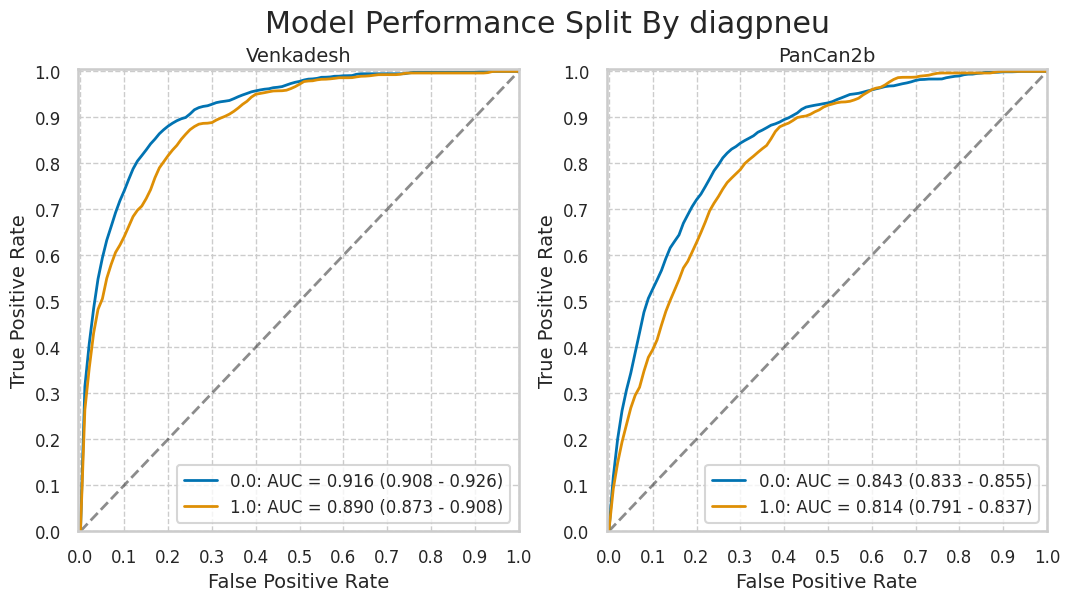

diagsarc


num        pct  num_mal    pct_mal
0.0  16021  99.651676     1241   7.746083
1.0     29   0.180382        5  17.241379

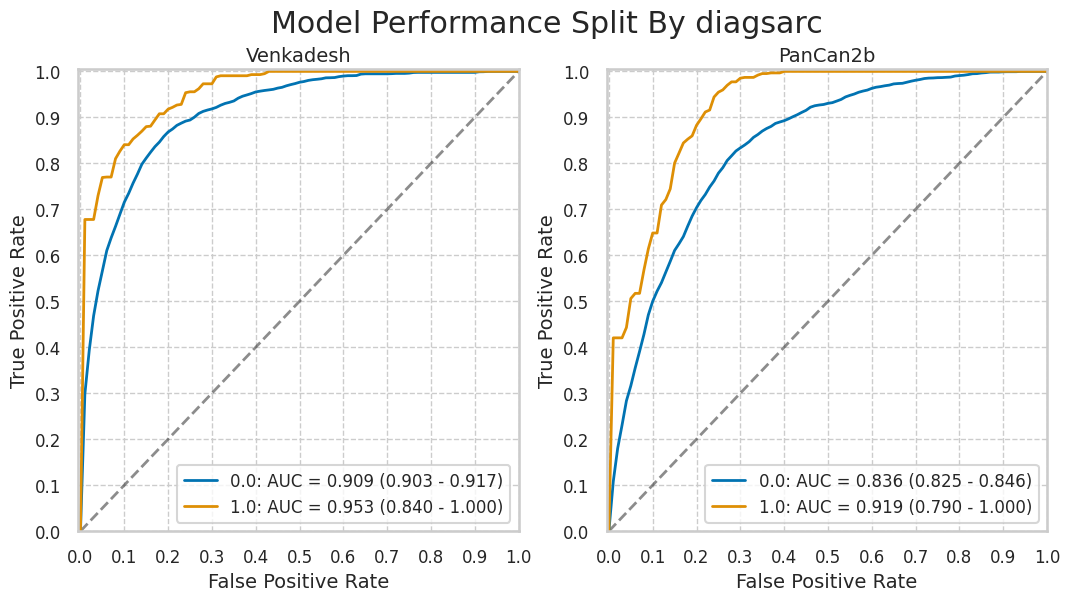

diagsili


num        pct  num_mal    pct_mal
0.0  16030  99.707657     1242   7.747973
1.0     20   0.124401        4  20.000000

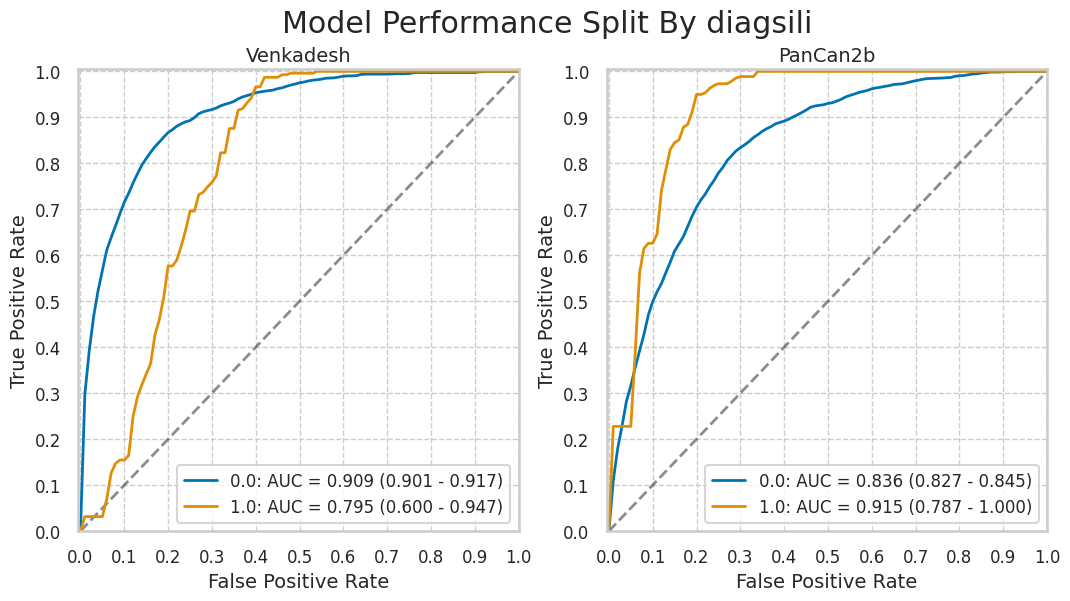

diagstro


num        pct  num_mal   pct_mal
0.0  15599  97.026808     1205  7.724854
1.0    463   2.879891       43  9.287257

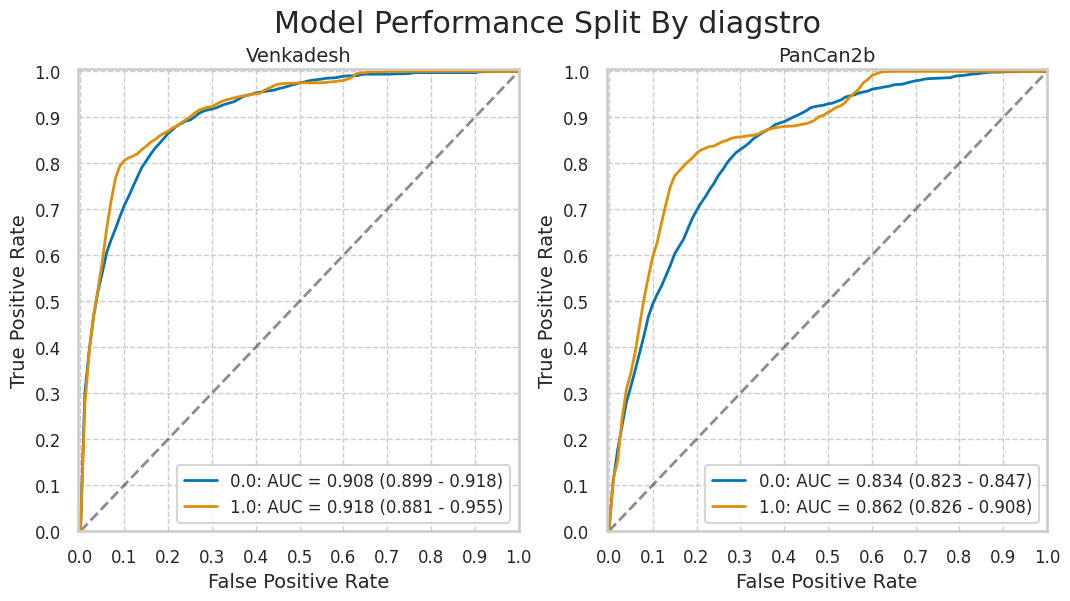

diagtube


num        pct  num_mal   pct_mal
0.0  15892  98.849288     1231  7.746036
1.0    166   1.032531       14  8.433735

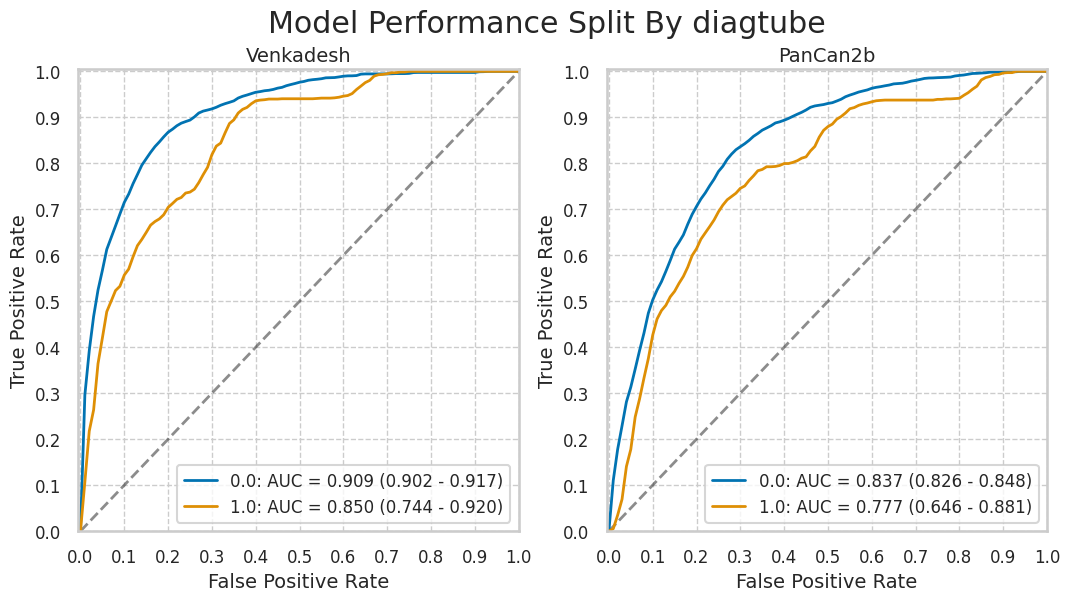

In [19]:
for cat in nlst_democols['cat']['disease']:
    print(cat)
    plot_by_category(nlst_preds, cat)

### Personal cancer history

cancblad


num        pct  num_mal   pct_mal
0.0  15929  99.079430     1234  7.746877
1.0    116   0.721528       11  9.482759

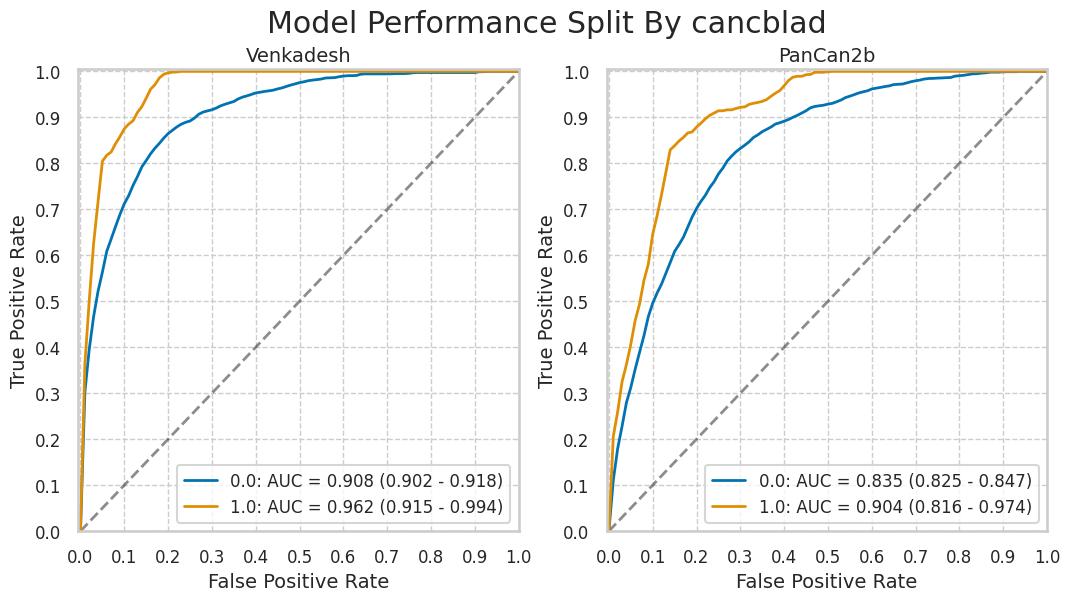

cancbrea


num        pct  num_mal    pct_mal
0.0  15820  98.401443     1218   7.699115
1.0    225   1.399515       27  12.000000

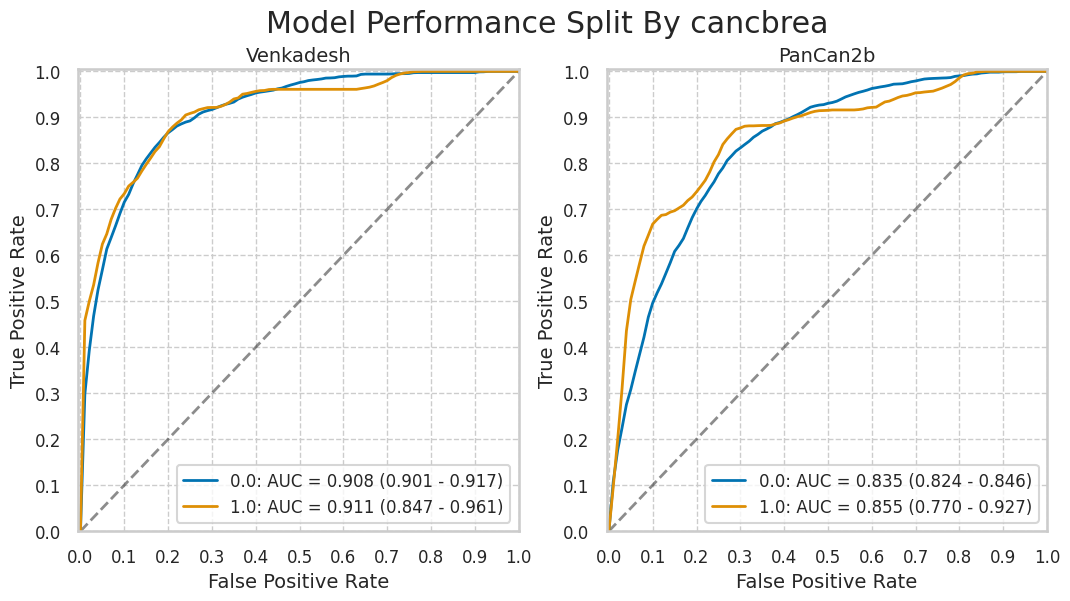

canccerv


num        pct  num_mal   pct_mal
0.0  15817  98.382783     1227  7.757476
1.0    233   1.449275       18  7.725322

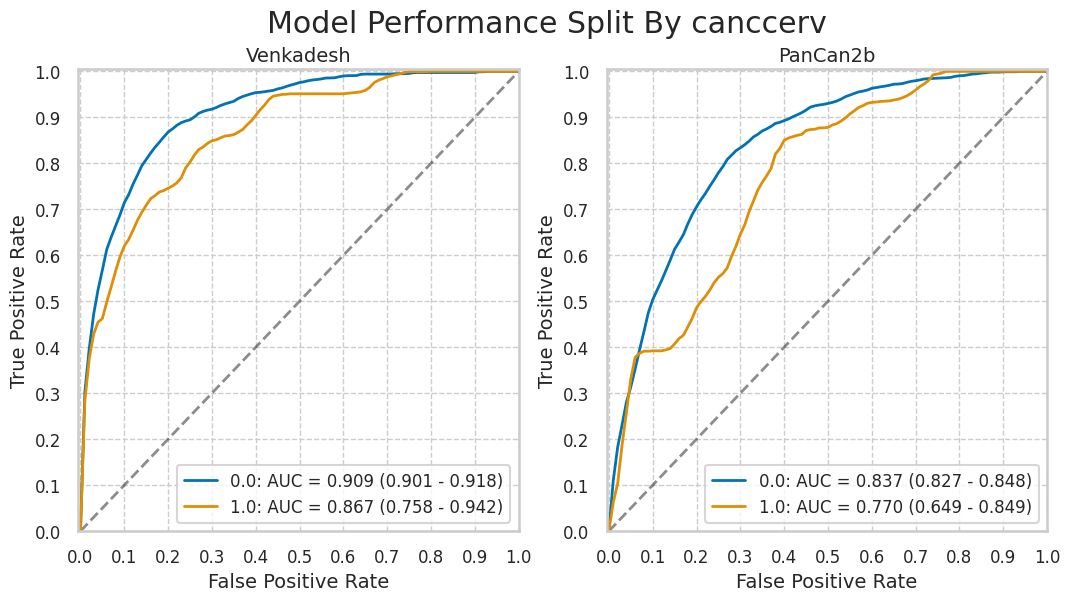

canccolo


num        pct  num_mal   pct_mal
0.0  15982  99.409094     1243  7.777500
1.0     70   0.435405        2  2.857143

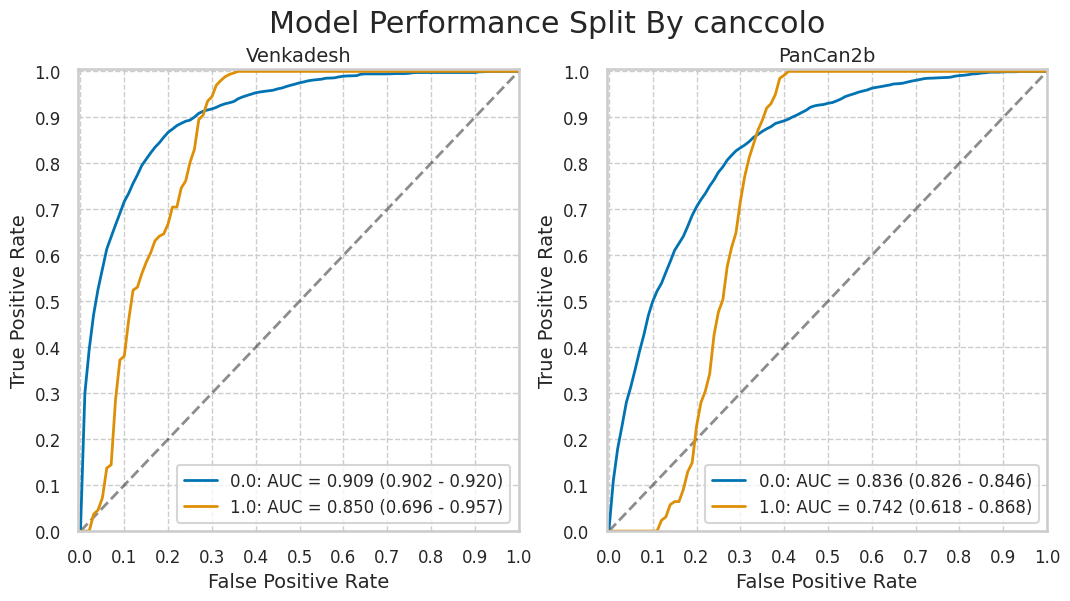

cancesop


num        pct  num_mal   pct_mal
0.0  16042  99.782298     1245  7.760878
1.0     10   0.062201        0  0.000000

Not plotting ROC since there are zero values for malignant or benign nodules :(
canckidn


num        pct  num_mal    pct_mal
0.0  16030  99.707657     1241   7.741734
1.0     22   0.136841        4  18.181818

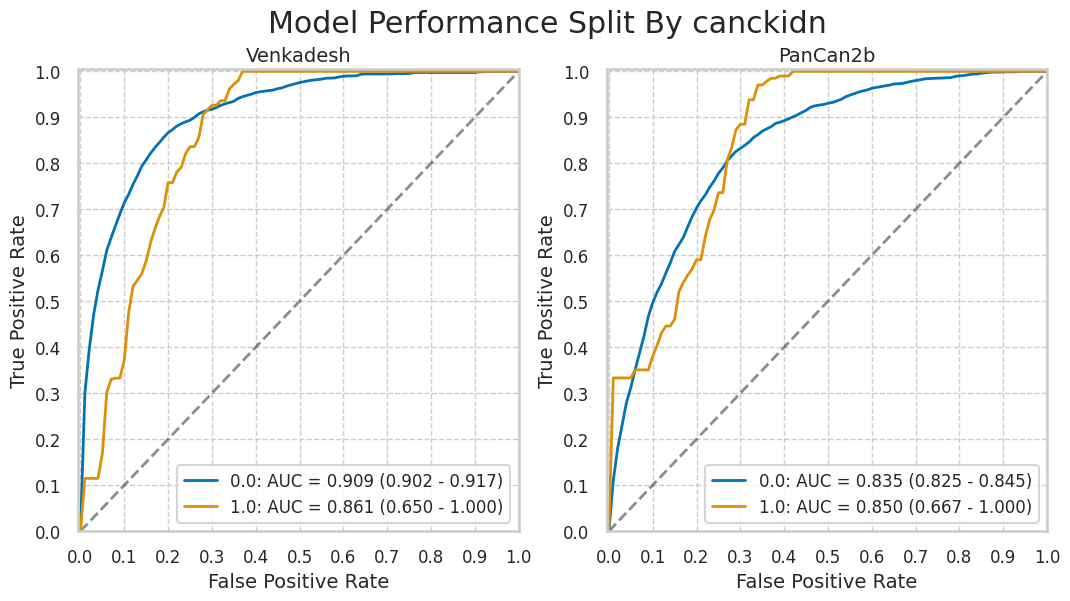

canclary


num        pct  num_mal    pct_mal
0.0  16042  99.782298     1244   7.754644
1.0     10   0.062201        1  10.000000

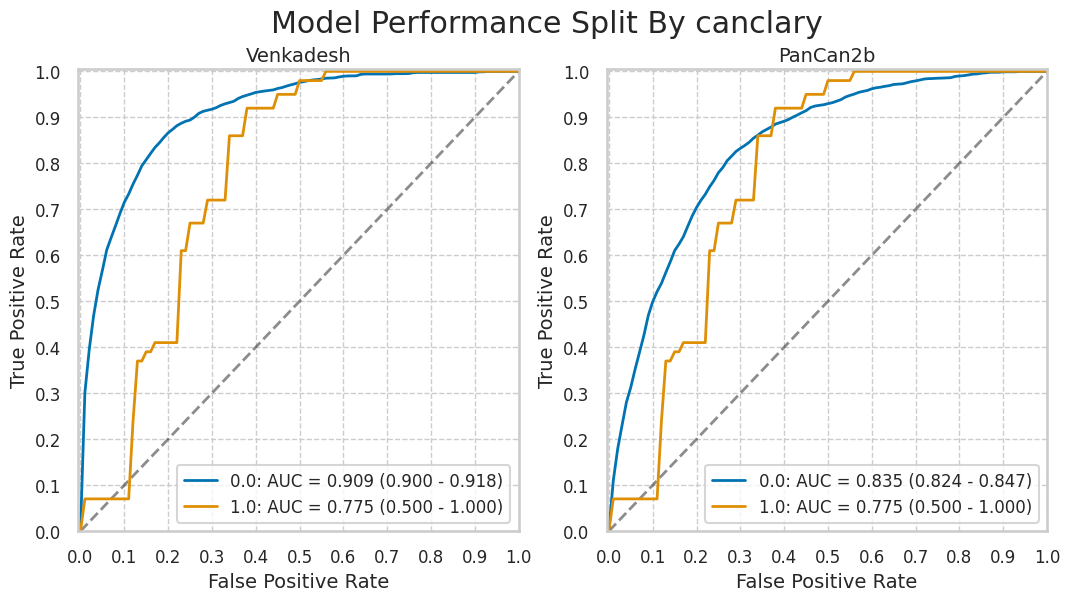

canclung


num        pct  num_mal    pct_mal
0.0  16048  99.819618     1242   7.739282
1.0      4   0.024880        3  75.000000

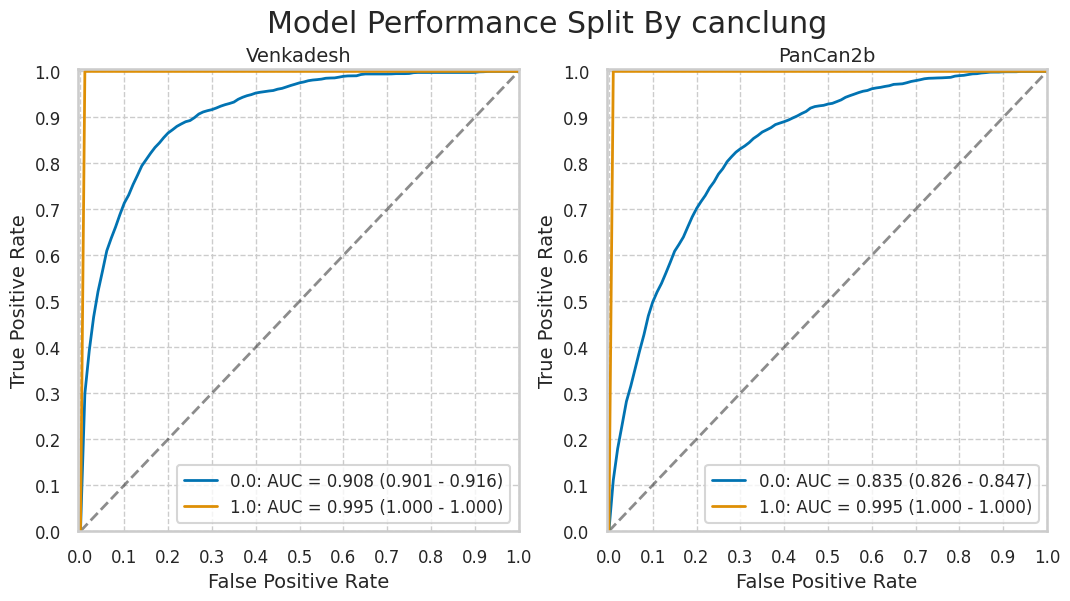

cancnasa


num        pct  num_mal   pct_mal
0.0  16030  99.707657     1242  7.747973
1.0     11   0.068421        1  9.090909

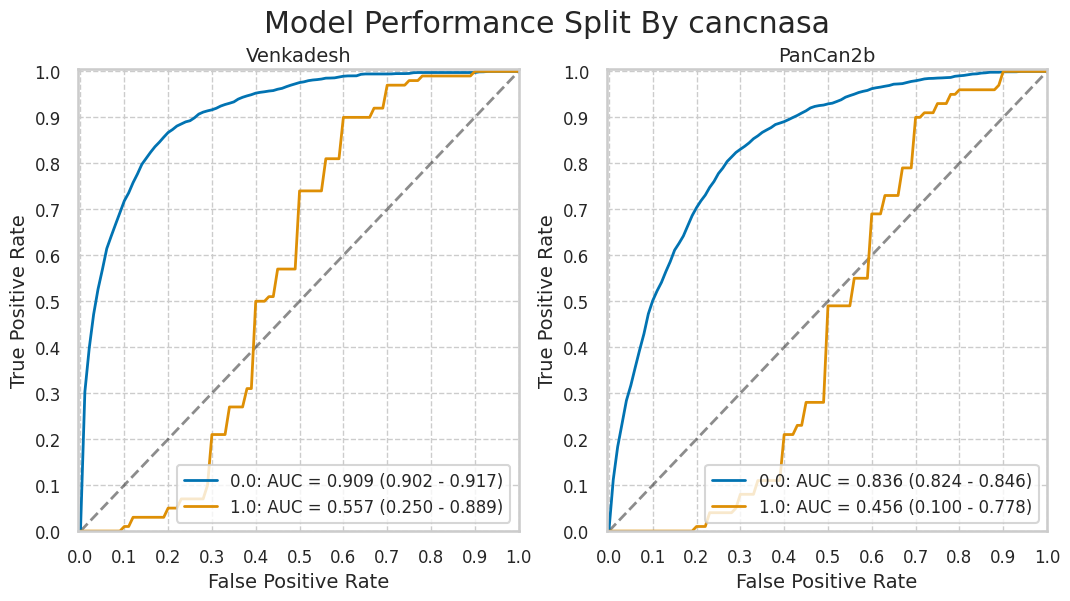

cancoral


num        pct  num_mal    pct_mal
0.0  16029  99.701437     1234   7.698546
1.0     22   0.136841       11  50.000000

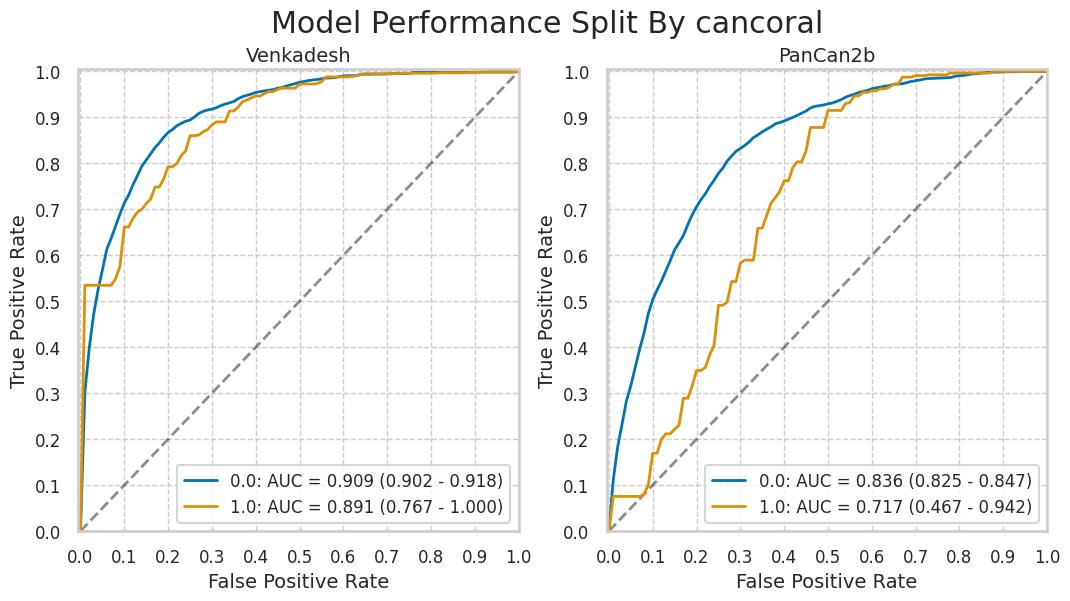

cancpanc


num        pct  num_mal   pct_mal
0.0  16052  99.844498     1245  7.756043

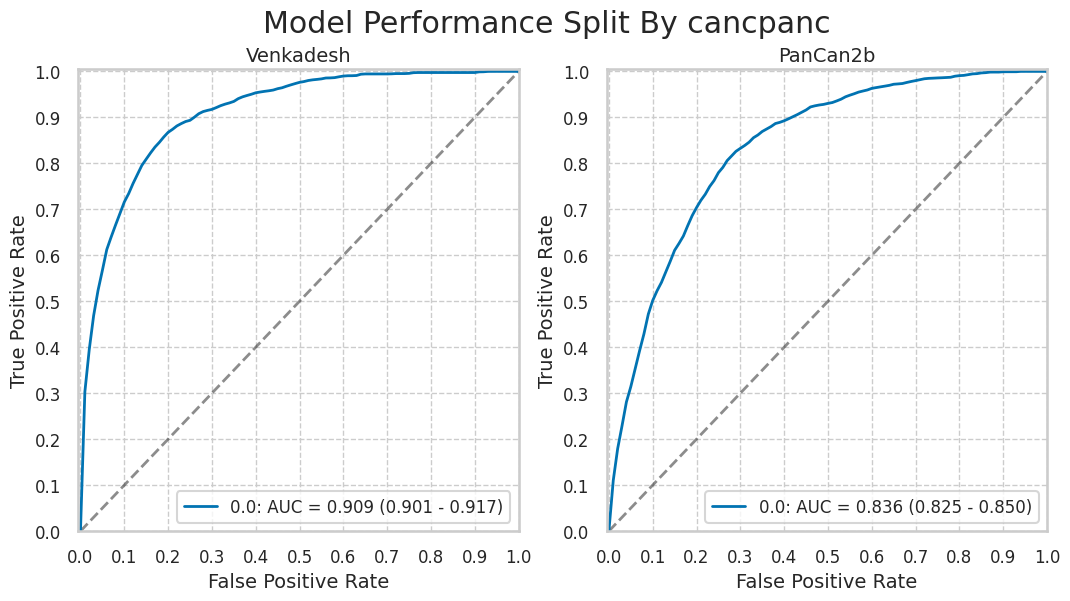

cancphar


num        pct  num_mal   pct_mal
0.0  16046  99.807178     1245  7.758943
1.0      6   0.037320        0  0.000000

Not plotting ROC since there are zero values for malignant or benign nodules :(
cancstom


num        pct  num_mal  pct_mal
0.0  16034  99.732537     1245  7.76475
1.0     18   0.111961        0  0.00000

Not plotting ROC since there are zero values for malignant or benign nodules :(
cancthyr


num        pct  num_mal    pct_mal
0.0  16017  99.626796     1242   7.754261
1.0     22   0.136841        3  13.636364

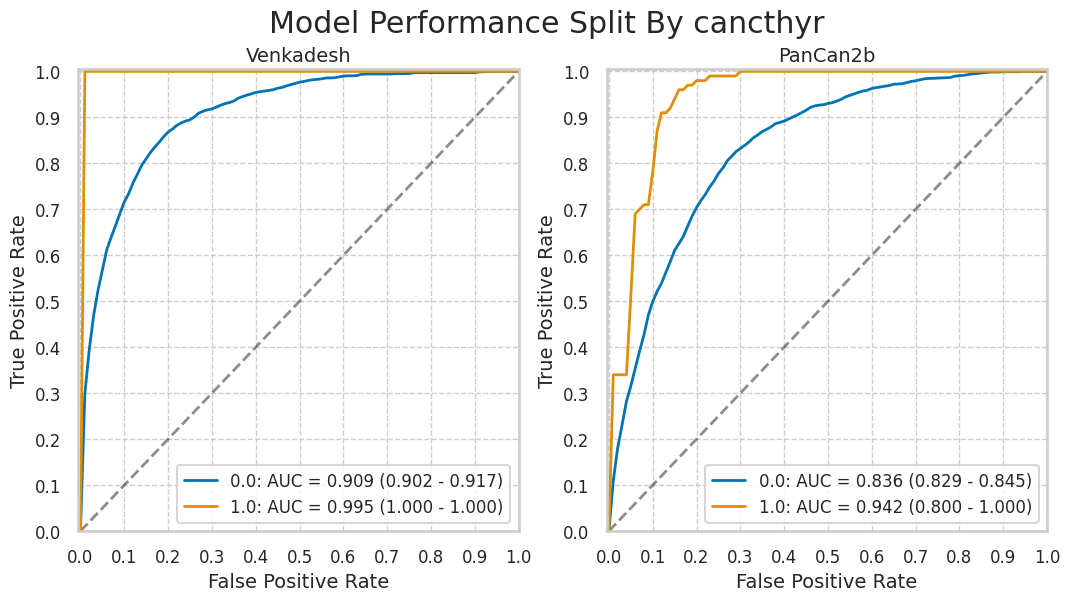

canctran


num        pct  num_mal     pct_mal
0.0  16042  99.782298     1242    7.742177
1.0      1   0.006220        1  100.000000

Not plotting ROC since there are zero values for malignant or benign nodules :(
FamilyHistoryLungCa


num       pct  num_mal   pct_mal
False  11979  74.51017      870  7.262710
True    4098  25.48983      379  9.248414

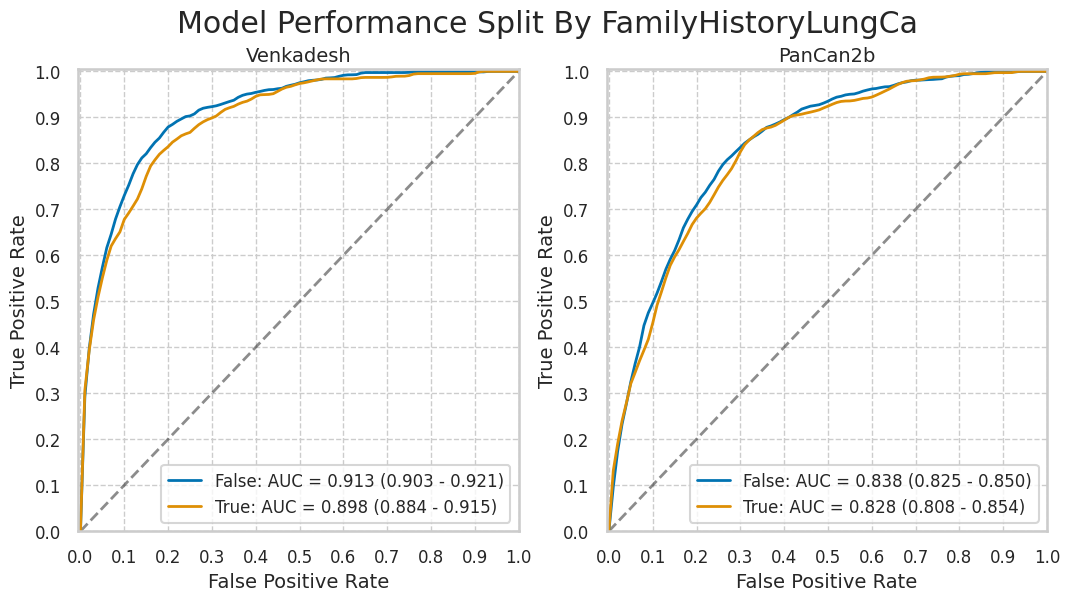

In [23]:
for cat in nlst_democols['cat']['canchist']:
    print(cat)
    plot_by_category(nlst_preds, cat)